<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON8_N_SKEWNESS_v528_Exchange_Select.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# @title Markov Markowitz Company / N-Skewness Strategy tester
# @markdown ---
# @markdown Input parameters for asset selection

EXCHANGE = "MIXED"  # @param ['CHAIKIN','dow30','CRYPTO','bist30', 'MIXED', 'XU_ONLY', 'US_Fav', 'ExtraOrdinaries', 'CIQTK_AU_08_06_2022', 'TR_Best']






# EPAT PROJECT Batch 52

## Moving Skewness Crossover (MSC) Strategy: Rationale, Construction and Backtesting

##### Developed by:
##### Alper Ülkü, Ankara, Turkey
##### alperulku1970@gmail.com
##### linkedin: https://www.linkedin.com/in/alperulku1970/

# Introduction

## Moving Sharpe Ratio Crossover(MSRC) and Moving Skewness Crossover (MSC) Strategy: Rationale, Construction and Backtesting

Synopsis: The moving averages cross over strategy is so well known since it is the basic, easy to understand and relatively easy to implement within trading algo universe.

I tried in this Project a similar strategy but it is called the “Moving Skewness Crossover Strategy”. Here are my assumptions:

1.	He et al., 2013 used skewness in detecting climatic changes, thus long-term skewness may serve for detecting trend of an asset. As every trading asset has seasons or trends. Season for trending can be determined via its skewness of daily returns for M days. This number of days M, varies for every asset, is characteristic of this asset in long term. Thus we safely define “season change of an asset” if M-day skewness of Daily returns changes sign (from negative to positive or positive to negative).

2.	We detect trend due to M-Day Skewness: skewness of the M-day daily returns.
-	We also define N-Skewness (N smaller than M) for an asset is the skewness close-to-close daily returns for N days. We will use N-Skewness for trade entry signal.
-	We will also use kurtosis for selecting the asset to trade. We need to opt for the assets with a certain Kurtosis limit to minimize risk.
-	We will optimize N, M, Skewness_Lower_Limit and Skewness_Upper_Limit for the specific asset.

Strategy: We propose to implement, with M > N > 0, M, N are integers:
- if N-Day-Skewness is GREATER than the value M-Day-Skewness we will square off and enter long trade (BUY)
- if N-Day-Skewness is LESS than the value M-Day-Skewness  we will square off and enter short trade. (SELL)

Herein we prepared Python code and backtested, compared this strategy with an moving average cross over strategy also optimized for SMA and LMA values.

#### References:
- He, W., Wan, S., Jiang, Y., Jin, H., Zhang, W., Wu, Q., & He, T. (2013). Detecting abrupt change on the basis of skewness: Numerical tests and applications. International Journal of Climatology, 33(12), 2713–2727. https://doi.org/10.1002/joc.3624


#### Important Notice: This code contains critical information that is competition sensitive and can only be only reviewed by Quantinsti.


# Table of contents
1. [IMPORT LIBRARIES](#import_lib)
2. [CONSTRUCT CLASS](#construct_class)
3. [SELECT AMONG DATASETS](#select_dataset)
4. [DOWNLOAD FROM YF OR GET DATA LOCALLY](#download_data)
5. [APPLY STRATEGY](#apply_str)
6. [PRINT RESULTS](#print_results)
7. [MY OWN PORTFOLIO PERFORMANCE](#my_pf_perf)
8. [TEARSHEET FOR MY PORTFOLIO](#pf_tearsheet)
9. [AN ALTERNATIVE PORTFOLIO OF BEST PERFORMING ASSETS](#alternative_pf)
10. [DETERMINE WEIGHTS OF THIS ALTERNATIVE PF](#determine_weights)
11. [OPTIONS CALCULATIONS](#options)



In [21]:

!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scipy
!pip3 install nsepy
!pip3 install datetime
!pip3 install time
!pip3 install seaborn
!pip3 install random
!pip3 install itertools
!pip3 install hmmlearn
!pip3 install yfinance
!pip3 install glob
!pip3 install yfinance
!pip3 install pyfolio
!pip3 install warnings
!pip3 install os
!pip3 install cvxpy

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


### IMPORT LIBRARIES <a name="import_lib"></a>

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from scipy.stats import pearson3
from scipy.optimize import minimize
from scipy.stats import skew



In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML

In [26]:
import random
from itertools import product
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

print(__doc__)

import matplotlib.pyplot as plt
from hmmlearn import hmm

from glob import glob
import yfinance as yf
import pyfolio as pf
import warnings
import os


Automatically created module for IPython interactive environment


In [27]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### CONSTRUCT CLASS <a name="construct_class"></a>

In [28]:
class CROSSOVER:
    ## class attribute: We can know the possible values for moving_average and metrics
    ## before creating an object of the class
    moving_average = ( "Simple","exponential","Skewness","Skewness_On_Close","VWAP", "M-Sharpe") # Determine strategy type here
    metrics        = { 'Sharpe':'Sharpe Ratio',                  # Determine metrics
                       'CAGR':'Compound Average Growth Rate',
                       'MDD':'Maximum Drawdown',
                       'NHR':'Normalized Hit Ratio',
                       'OTS':'Optimal trade size'}

    def __init__(self,data,short_window = 20, long_window = 50,
                 moving_average = "Skewness", data_name = None, start = None,end = None ):

        """
         Doc string of the class. We define what class is about here
        """
        self.data=data #the dataframe
        #self.data['Date'] = pd.to_datetime(self.data['Date'], errors='coerce') # extra added on 30.01.2024
        self.data['Date'] = pd.to_datetime(self.data.Date, format='%Y-%m-%d', utc=True)
        self.data['yr'] = self.data['Date'].dt.year


        self.moving_average = moving_average
        if data_name is None:#the name that will appear on plots
            self.data_name = moving_average
        else:
            self.data_name=data_name
        self.short_window = short_window
        self.long_window = long_window
        self.n_days = (self.data.Date.iloc[-1] - self.data.Date.iloc[0])
        self.start=start #the beginning date of the sample period
        self.end=end #the ending date of the sample period

    def generate_signals(self, DELTA_SKEW=0, charts=True, burn=False, stock_name="AKBNK.IS" ):
        """
        This is an instance method. Only works on an object.
        """
        if self.long_window <= self.short_window: return   # short window cannot be greater than or equal to long window

        if self.moving_average == "Simple":
            self.data["SMA"] = self.data['Close'].rolling(window=self.short_window).mean()
            self.data["LMA"] = self.data['Close'].rolling(window=self.long_window).mean()
        elif self.moving_average == "exponential":
            self.data["SMA"] = self.data['Close'].ewm(span = self.short_window, adjust=True).mean()
            self.data["LMA"] = self.data['Close'].ewm(span = self.long_window, adjust=True).mean()
        elif self.moving_average == "Skewness":
            self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1)).dropna()
            self.data["SMA"] = self.data.Return.rolling(window=self.short_window).skew()
            self.data["LMA"] = self.data.Return.rolling(window=self.long_window).skew()
        elif self.moving_average == "VWAP":
            self.data['VWAP'] = (self.data.Volume * (self.data.High + self.data.Low) / 2).cumsum() / self.data.Volume.cumsum()
            self.data["Typical_Price"] = (self.data.High + self.data.Low + self.data['Close'] ) / 3
            self.data["SMA"] = self.data.VWAP
            self.data["LMA"] = self.data.Typical_Price
        elif self.moving_average == "M-Sharpe":
            self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1)).dropna()
            self.data["SMA"] = (self.data.Return.rolling(window=self.short_window).mean() / self.data.Return.rolling(window=self.short_window).std()) * (252**0.5)
            self.data["LMA"] = (self.data.Return.rolling(window=self.long_window).mean() / self.data.Return.rolling(window=self.long_window).std()) * (252**0.5)
        else:
            raise Exception("Not a valid type")

        self.data["_lag1_SMA"] = self.data.SMA.shift(1)
        self.data["_lag1_LMA"] = self.data.LMA.shift(1)

        ## creating signal
        buy_mask = (self.data.LMA > 0) & (self.data.SMA > self.data.LMA ) & (self.data._lag1_SMA < self.data._lag1_LMA)
        sq_off_mask = (((self.data.LMA > 0) & (self.data.SMA < self.data.LMA ) & (self.data._lag1_SMA > self.data._lag1_LMA)) | ((self.data.LMA < 0) & (self.data.SMA > self.data.LMA ) & (self.data._lag1_SMA < self.data._lag1_LMA)))
        sell_mask= (self.data.LMA < 0) & (self.data.SMA < self.data.LMA ) & (self.data._lag1_SMA > self.data._lag1_LMA)


        self.data['signal'] = np.nan
        self.data.loc[buy_mask,'signal'] = +1
        self.data.loc[sell_mask,'signal'] = -1
        self.data.loc[sq_off_mask, 'signal'] = 0

        self.data['Delta'] = self.data.SMA - self.data.LMA

        if burn:
            burn_period = 2*self.long_window
            self.data.loc[:burn_period,"signal"] = np.nan
        self.data.signal = self.data.signal.fillna(method="ffill")

        mask = (self.data.signal != self.data.signal.shift(1)) & (self.data.signal.notnull())
        self.data['trade_num'] = np.where(mask,1,0).cumsum()

        ## display chart
        if charts:
            plt.plot(self.data['Date'],self.data['SMA'],color='red', label=f'SMA = {self.short_window}')
            plt.plot(self.data['Date'],self.data['LMA'],color='blue', label=f'LMA = {self.long_window}')

            #******** DELTA SKEWNESS PLOT EKLEDİK *************************
            plt.plot(self.data['Date'],self.data['Delta'],color='green')

            #plt.title('%s %s Strategy Backtest'%(self.data_name)%(stock_name) )
            plt.title(f"{stock_name} {self.data_name} Strategy Backtest")
            plt.legend(loc=0)
            d_color = {}
            d_color[1] = '#90ee90'  ## light green
            d_color[-1] = "#ffcccb" ## light red

            j = 0
            for i in range(1,self.data.shape[0]):
                if np.isnan(self.data.signal[i-1]):
                    j=i
                elif (self.data.signal[i-1] == self.data.signal[i]) and (i< (self.data.shape[0]-1)):
                    continue
                else:
                    # plt.axvspan(self.data['Date'][j], self.data['Date'][i],
                    #            alpha=0.5, color=d_color[self.data.signal[i-1]], label="interval")
                    plt.axvspan(self.data['Date'][j], self.data['Date'][i],
                               alpha=0.5, label="interval")

                    j = i
            plt.grid(True)
            plt.show()
        return self.data.Delta

    def signal_performance(self, allocation):
        """
        Another instance method
        """
        if self.long_window <= self.short_window: return
        self.allocation=allocation

        #creating returns and portfolio value series
        self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1))

        self.data['S_Return']=self.data['signal'].shift(1)*self.data['Return']
        self.data['Market_Return']=self.data['Return'].expanding().sum()
        self.data['Strategy_Return']=self.data['S_Return'].expanding().sum()
        self.data['Portfolio Value']=((self.data['Strategy_Return']+1)*self.allocation)
        self.data['Wins']=np.where(self.data['S_Return'] > 0,1,0)
        self.data['Losses']=np.where(self.data['S_Return'] < 0,1,0)

        ## Daywise Performance
        d_perform = {}
        d_perform['Returns']=self.data['Return'].sum()
        d_perform['R_Mean']=self.data['Return'].mean()
        d_perform['R_Std_Dev']=self.data['Return'].std()
        d_perform['R_Skew']=self.data['Return'].skew() # 12 day window for skew
        d_perform['R_Kurtosis']=self.data['Return'].kurt()
        d_perform['R_Sharpe'] = self.data["Return"].mean() / self.data["Return"].std() * (252**.5)

        d_perform['Str_Returns']=self.data['S_Return'].sum()
        d_perform['Str_R_Mean']=self.data['S_Return'].mean()
        d_perform['Str_R_Std_Dev']=self.data['S_Return'].std()
        d_perform['Str_R_Skew']=self.data['S_Return'].skew()
        d_perform['Str_R_Kurtosis']=self.data['S_Return'].kurt()
        d_perform['SharpeRatio'] = self.data["S_Return"].mean() / self.data["S_Return"].std() * (252**.5)

        d_perform['TotalWins']=self.data['Wins'].sum()
        d_perform['TotalLosses']=self.data['Losses'].sum()
        d_perform['TotalTrades']=d_perform['TotalWins']+d_perform['TotalLosses']

        d_perform['HitRatio']=round(d_perform['TotalWins']/d_perform['TotalTrades'],2)
        d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
        d_perform['MaxDrawdown']=(1.0-self.data['Portfolio Value']/self.data['Portfolio Value'].cummax()).max()


        self.daywise_performance = pd.Series(d_perform)

        ## Tradewise performance
        _df = self.data.groupby(["signal","trade_num"]).S_Return.sum().reset_index()
        _df['Wins']  =np.where(_df['S_Return'] > 0,1,0)
        _df['Losses']=np.where(_df['S_Return'] < 0,1,0)
        d_tp = {}
        d_tp.update(_df[["Wins","Losses"]].sum().rename({'Wins':'TotalWins','Losses':'TotalLosses'}).to_dict())
        d_tp['TotalTrades'] = d_tp["TotalWins"] + d_tp["TotalLosses"]
        d_tp['HitRatio'] =  np.round(d_tp["TotalWins"] / d_tp['TotalTrades'],4)
        d_tp['AvgWinRet'] = np.round(_df[_df.Wins==1].S_Return.mean(),4)
        d_tp['AvgLossRet'] = np.round(_df[_df.Losses==1].S_Return.mean(),4)
        d_tp['WinByLossRet'] = np.round(abs(d_tp['AvgWinRet']/d_tp['AvgLossRet']),2)
        d_tp['RetVar'] = np.round(_df.S_Return.std(),4)
        _sum = _df.groupby("Wins").S_Return.sum()
        d_tp['NormHitRatio'] = np.round(_sum[1]/_sum.abs().sum(),4)
        d_tp['OptimalTradeSize'] = self.kelly(p = d_tp['HitRatio'], b = d_tp['WinByLossRet'])
        self.tradewise_performance = pd.Series(d_tp)

    @staticmethod
    def kelly(p,b):
        """
        Static method: No object or class related arguments
        p: win prob, b: net odds received on wager, output(f*) = p - (1-p)/b

        Spreadsheet example
            from sympy import symbols, solve, diff
            x = symbols('x')
            y = (1+3.3*x)**37 *(1-x)**63
            solve(diff(y, x), x)[1]
        Shortcut
            .37 - 0.63/3.3
        """
        return np.round(p - (1-p)/b,4)

    def plot_performance(self, allocation=1, charts=True, stock_name = "AKBNK.IS"):
        #intializing a variable for initial allocation
        #to be used to create equity curve
        self.signal_performance(allocation)

        #yearly performance
        self.yearly_performance()

        #Plotting the Performance of the strategy
        if (charts == True):
            plt.plot(self.data['Date'],self.data['Market_Return'],color='red', label='Market Returns')
            plt.plot(self.data['Date'],self.data['Strategy_Return'],color='blue', label= 'Strategy Returns')
            #plt.title('%s Strategy Backtest'%(self.data_name))
            plt.title(f"{stock_name} {self.data_name} Strategy Backtest")
            plt.legend(loc=0)
            plt.tight_layout()
            plt.grid(True)
            plt.show()

            #pf.create_simple_tear_sheet(self.data['Portfolio Value'], benchmark_rets=True)

            plt.plot(self.data['Date'],self.data['Portfolio Value'], color='blue')
            #plt.title('%s Portfolio Value'%(self.data_name))
            plt.title(f"{stock_name} {self.data_name} Portfolio Value")
            plt.grid(True)
            plt.show()

    def yearly_performance(self):
        """
        Instance method
        Adds an instance attribute: yearly_df
        """
        _yearly_df = self.data.groupby(['yr','signal']).S_Return.sum().unstack()
        _yearly_df.rename(columns={-1.0:'Sell',1.0:'Buy'}, inplace=True)
        _yearly_df['Return'] = _yearly_df.sum(1)

        # yearly_df
        self.yearly_df = _yearly_df.style.bar(color=["#ffcccb",'#90ee90'], align = 'zero').format({
            'Sell': '{:,.2%}'.format,'Buy': '{:,.2%}'.format,'Return': '{:,.2%}'.format})


    def update_metrics(self):
        """
        Called from the SMA_LMA_matrix class method
        """
        d_field = {}
        if self.long_window > self.short_window:
            d_field['Sharpe'] = self.daywise_performance.SharpeRatio
            d_field['CAGR'] = self.daywise_performance.CAGR
            d_field['MDD'] = self.daywise_performance.MaxDrawdown
            d_field['NHR'] = self.tradewise_performance.NormHitRatio
            d_field['OTS'] = self.tradewise_performance.OptimalTradeSize

        return d_field

    @classmethod
    def SMA_LMA_matrix(cls,data, LMA_range, SMA_range, metrics, moving_average = "exponential", optimal_sol = True, charts = True):
        """
        This is a class method. First argument is a class.
        """
        c_green = sns.light_palette("green", as_cmap=True)
        c_red = sns.light_palette("red", as_cmap=True)

        d_mats = {m:[] for m in metrics}

        for l in LMA_range:
            d_row = {m:[] for m in metrics}
            for s in SMA_range:
                obj = cls(data, s, l, moving_average) ## object being created from the class
                obj.generate_signals(charts=False)
                obj.signal_performance(100)
                d_field = obj.update_metrics()
                for m in metrics: d_row[m].append(d_field.get(m,np.nan))
            for m in metrics: d_mats[m].append(d_row[m])

        d_df = {m:pd.DataFrame(d_mats[m], index=LMA_range, columns=SMA_range) for m in metrics}

        def optimal(_df):
            """
            This is a function inside a function.
            We could have created it outside the class if needed, but that would made it harder to relate.
            """
            _df = _df.stack().rank()
            _df = (_df - _df.mean())/_df.std()
            return _df.unstack()

        if optimal_sol:
            d_df['Signal'] = 0
            if 'Sharpe' in metrics: d_df['Signal'] += 2*optimal(d_df['Sharpe']) #2*optimal(d_df['Sharpe'])
            if 'NHR' in metrics: d_df['Signal'] += optimal(d_df['NHR'])
            if 'CAGR' in metrics: d_df['Signal'] += optimal(d_df['CAGR']) #optimal(d_df['CAGR'])
            if 'MDD' in metrics: d_df['Signal'] -= 2*optimal(d_df['MDD'])   #2*optimal(d_df['MDD'])

            l_i,s_i = np.unravel_index(np.nanargmax(d_df['Signal'].values), d_df['Signal'].shape)
            print(f"Most optimal cross-over pair is SMA:{SMA_range[s_i]}, LMA:{LMA_range[l_i]}")
            metrics.insert(0,'Signal')

        if (charts==True):
            for m in metrics:
                display(HTML(d_df[m].style.background_gradient(axis=None, cmap=
                    c_red if m=="MDD" else c_green).format(
                    ("{:,.2}" if m in ["Sharpe","Signal"] else "{:.2%}")).set_caption(m).render()))

        return d_df, SMA_range[s_i], LMA_range[l_i]



    def drawdowns(equity_curve):
        i = np.argmax(np.maximum.accumulate(equity_curve.values) - equity_curve.values) # end of the period
        j = np.argmax(equity_curve.values[:i]) # start of period

        drawdown=abs(100.0*(equity_curve[i]-equity_curve[j]))

        DT=equity_curve.index.values

        start_dt=pd.to_datetime(str(DT[j]))
        MDD_start=start_dt.strftime ("%Y-%m-%d")

        end_dt=pd.to_datetime(str(DT[i]))
        MDD_end=end_dt.strftime ("%Y-%m-%d")

        NOW=pd.to_datetime(str(DT[-1]))
        NOW=NOW.strftime ("%Y-%m-%d")

        MDD_duration=np.busday_count(MDD_start, MDD_end)

        try:
            UW_dt=equity_curve[i:].loc[equity_curve[i:].values>=equity_curve[j]].index.values[0]
            UW_dt=pd.to_datetime(str(UW_dt))
            UW_dt=UW_dt.strftime ("%Y-%m-%d")
            UW_duration=np.busday_count(MDD_end, UW_dt)
        except:
            UW_dt="0000-00-00"
            UW_duration=np.busday_count(MDD_end, NOW)
        return MDD_start, MDD_end, MDD_duration, drawdown, UW_dt, UW_duration


### SELECT AMONG DATASETS <a name="select_dataset"></a>

In [29]:
US_Top_10 = [  "IBM", "TSLA", "MSFT","VZ", "TGT","WFC","NVDA","BA","GOOG"]

US_Best = [ "NVDA", "MRK", "WMT", "JNJ", "JPM", "WBA" ]

LSE = [ "CRDA.L", "BRBY.L", "STJ.L", "AAL.L", "RTO.L", "TSCO.L"]

CRYPTOS = [ "BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "STETH-USD", "ADA-USD", "AVAX-USD" ]

Metals =   [    "GC=F","SI=F", "CL=F", "PA=F",   "PL=F", "ALI=F"]

TSLA =[ "TSLA", "AMZN", "GOOGL" ]

DOW30 =[ "TSLA","AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","INTC",
         "JNJ","KO","JPM","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM",
         "VZ","V","WBA","WMT","DIS","DOW"]

CHAIKIN = [ "FTNT", "NDAQ", "BX", "LYV", "FFIV", "FANG", "FMC", "FCPI"]


BIST30 = [ "AKBNK","ALARK","ARCLK","ASTOR","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","PETKM","PGSUS","SAHOL","SASA",
          "ODAS","SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK","EUPWR"]

US_Stocks =      [ "GE", "PYPL",
                   "SYNA","QCOM","NVDA","NFLX","AVGO","FSLR","FB",
                   "BAC", "AMZN","T",   "GOOG","TSLA",
                   "XOM", "C",   "DIS",
                   "WFC", "GM",  "TGT", "SBUX", "ORCL",
                   "NVDA","FDX", "CL",  "TM",   "STT", "GDX", "NXPI", "OLED",
                   "NKE", "CVS", "BIDU", "BABA" ]

BIST50 = [ "XU100.IS","AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS"
       ]

BIST100_1 = [ "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "INDES.IS","ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
           "AYDEM.IS","BAGFS.IS" ]

BIST100_2 = [ "ALGYO.IS", "BRMEN.IS", "CANTE.IS", "CCOLA.IS", "CEMAS.IS", "CIMSA.IS",
           "CMENT.IS","DENGE.IS", "DEVA.IS", "DOAS.IS", "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
           "ERBOS.IS", "ESEN.IS", "ETILR.IS", "GENIL.IS", "GESAN.IS", "GLYHO.IS", "GOZDE.IS", "ISBIR.IS",
           "ISDMR.IS", "ISFIN.IS", "ISGYO.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",
           "KLNMA.IS", "KORDS.IS", "KRVGD.IS", "LOGO.IS", "MAVI.IS", "NTHOL.IS", "OTTO.IS", "OYAKC.IS",
           "PARSN.IS", "PETKM.IS", "PGSUS.IS", "QNBFB.IS", "QNBFL.IS", "QUAGR.IS", "RTALB.IS", "SARKY.IS",
           "SELEC.IS", "TBORG.IS", "TKNSA.IS", "TRGYO.IS", "ULKER.IS", "UTPYA.IS",
           "VERUS.IS", "YATAS.IS", "ZOREN.IS", "ZRGYO.IS"
          ]

BIST100EX = [ "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
            "GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS", #garan çıktı
            "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",

            "THYAO.IS","TUPRS.IS", "GUBRF.IS", # XU100  CLEBI attık BERA ekledik VESBE attık
            "HEKTS.IS","INDES.IS",
            "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
            "KORDS.IS","TKFEN.IS","EREGL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
            "ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS",
            "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
            "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
            "BAGFS.IS","BRMEN.IS","CEMAS.IS", "CIMSA.IS", # CANTE, AYDEM CCOLA attık
            "CMENT.IS","DENGE.IS","DEVA.IS" , "DOAS.IS" , "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
            "ERBOS.IS","ETILR.IS","GOZDE.IS", "ISBIR.IS", # GLYHO attık
            "ISDMR.IS","ISFIN.IS","ISGYO.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",
            "KLNMA.IS","LOGO.IS" ,"MAVI.IS" , "NTHOL.IS", "OTTO.IS", "OYAKC.IS",
            "PARSN.IS","PGSUS.IS","QNBFB.IS", "QNBFL.IS", "RTALB.IS", "SARKY.IS", # QUAGR attık
            "SELEC.IS","TBORG.IS","TKNSA.IS", "TRGYO.IS", "ULKER.IS", "UTPYA.IS",
            "VERUS.IS","YATAS.IS","ZOREN.IS", "ETH-USD", "BTC-USD", "GC=F", "TRY=X", "CL=F", "SI=F"
          ]


BIST50EX = [ "AKSA.IS" ,"AKSEN.IS", "ALARK.IS","ARDYZ.IS", "ARENA.IS", "ARSAN.IS","ASELS.IS",
             "BERA.IS" ,"BIMAS.IS","BRYAT.IS", "CLEBI.IS", "DOHOL.IS", "EKGYO.IS","FROTO.IS",
             "GLYHO.IS","GUBRF.IS","GARAN.IS", "GSDHO.IS", "HDFGS.IS", "HALKB.IS",
             "HEKTS.IS","IPEKE.IS","INDES.IS", "INFO.IS" , "ISMEN.IS",
             "KAREL.IS","KRDMD.IS", "KORDS.IS", "KARSN.IS",
             "KOZAA.IS","MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS", "PKART.IS","PETKM.IS",
             "SASA.IS" ,"SKTAS.IS", "SKBNK.IS", "SOKM.IS" ,
             "TAVHL.IS","TTRAK.IS","TCELL.IS", "TOASO.IS", "TSKB.IS" , "TURSG.IS", "TKFEN.IS",
             "TUPRS.IS","VESBE.IS", "VAKBN.IS", "VESTL.IS", "YKBNK.IS", "AKCNS.IS", "YATAS.IS", "AEFES.IS"
           ]

BIST100 = [

           "AEFES.IS", "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "INDES.IS","ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
           "AYDEM.IS","BAGFS.IS",

           "ALGYO.IS", "BRMEN.IS", "CANTE.IS", "CCOLA.IS", "CEMAS.IS", "CIMSA.IS",
           "CMENT.IS", "DEVA.IS",  "DOAS.IS",  "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
           "ERBOS.IS", "ETILR.IS", "GOZDE.IS", "ISBIR.IS",
           "ISDMR.IS", "ISFIN.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",  "ISGYO.IS", #GCM'de sorunlu
           "KLNMA.IS", "MAVI.IS",  "NTHOL.IS", "OTTO.IS",  "OYAKC.IS",
           "PARSN.IS", "PETKM.IS", "QNBFL.IS", "QUAGR.IS", "RTALB.IS", "SARKY.IS",
           "SELEC.IS", "TBORG.IS", "TKNSA.IS", "TRGYO.IS", "ULKER.IS", # "UTPYA.IS" ve GCM'de sorunlu
           "VERUS.IS", "YATAS.IS", "ZOREN.IS" #, "GLHYO.IS"
           ]

# 4 hisseyi hata vermesi sebebiyle dışarıda bıraktık, ARCLK, YKBNK, BRLSM, ESCAR

MIXED  =   [ "XU030.IS", "XU100.IS","KOZAL.IS" , "THYAO.IS",  "YKBNK.IS", "ETH-USD" , "BTC-USD" , "GC=F","SI=F", "CL=F", "TRY=X" , "LSEG.L", "^DJI"]



XU_ONLY =   [ "XU030.IS", "XU100.IS"]
US_Fav   =   [   "AMD"]
ExtraOrdinaries = [ "CANTE.IS" ]

CIQTK_AU_08_06_2022 = [  "KOZAA.IS", "THYAO.IS" , "CANTE.IS",  "QUAGR.IS",  "ISGYO.IS" ]

working_dir = "/Users/alperulku/EPAT-99-FINAL PROJECT/EPAT PROJECT WORK/"
working_dir = "\\ALL_FILES\\100_FINANCE\\EPAT\\ALL MODULES\\EPAT-99-FINAL PROJECT\\EPAT PROJECT WORK"

#os.chdir(working_dir+"\\BIST100")
exchange = MIXED


import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)


TR_Best  =  [
"KCHOL.IS",
"AKBNK.IS",
"INFO.IS",
"QNBFB.IS",
"GUBRF.IS",
"BRYAT.IS",
"RTALB.IS",
"OTKAR.IS",
"ARDYZ.IS",
"BRMEN.IS",
"GOZDE.IS",
"IPEKE.IS",
"FROTO.IS"
]

Portfolio_Assets = [ "XU100.IS", "BIMAS.IS", "FROTO.IS" , "TCELL.IS", "GC=F", "TRY=X", "ETH-USD", "CL=F", "BERA.IS" ]


Gold_Only = ["GC=F"]


My current directory is : /content
My directory name is : content


In [30]:
if EXCHANGE == "CRYPTO":
  stock_list = CRYPTOS
elif EXCHANGE == "dow30":
  stock_list = DOW30
elif EXCHANGE == "CHAIKIN":
  stock_list = CHAIKIN
elif EXCHANGE == "MIXED":
  stock_list = MIXED
elif EXCHANGE == "bist30":
  stock_list = BIST30
elif EXCHANGE == "XU_ONLY":
  stock_list = XU_ONLY
elif EXCHANGE == "US_Fav":
  stock_list = US_Fav
elif EXCHANGE == "ExtraOrdinaries":
  stock_list = ExtraOrdinaries
elif EXCHANGE == "CIQTK_AU_08_06_2022":
  stock_list = CIQTK_AU_08_06_2022
elif EXCHANGE == "TR_Best":
  stock_list = TR_Best

Portfolio_Assets = stock_list

#Gold_Only

In [31]:
len(stock_list)

13

### DOWNLOAD DATA OR GET DATA FROM READY CSV FILES <a name="download_data"></a>

In [32]:
LENGTH = 64
#os.chdir(working_dir+"\\BIST100")

start_time = datetime.now()
new_download = True

START_DATE = '2018-02-13'
END_DATE   = '2023-12-26'
price_list = []

if new_download:
    print(LENGTH*"*")
    print("Starting Download ...")
    print(LENGTH*"*")
    for tick in stock_list:
        print(f"Downloading {tick}")
        yf_tick = yf.Ticker(tick)
        df = yf_tick.history(interval='1d', auto_adjust=True, start=START_DATE, end=END_DATE, back_adjust = True, rounding=True)
        df['Close'] = df['Close'].mask( (tick == "XU100.IS" or tick == "XU030.IS") & (df['Close'] > 10000), other = df['Close'] / 100.0)
        df.dropna(how='all', inplace=True)
        price_list.append(df)
    print(LENGTH*"*")
    print('Download complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
    print(LENGTH*"*")

## Save datafiles to disk

    for i,df in enumerate(price_list):
        df.to_csv(f"{stock_list[i]}.csv")
else:
    price = {}
    print(LENGTH*"*")
    print("Fetching Downloaded CSV Files ...")
    print(LENGTH*"*")
    for tick in stock_list:
        print(f"Fetching {tick}")
        filename = f"{tick}.csv"
        df = pd.read_csv(filename)
        price[tick] = df
    print(LENGTH*"*")
    print('Done ...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
    print(LENGTH*"*")



****************************************************************
Starting Download ...
****************************************************************
****************************************************************
Download complete...Time elapsed (hh:mm:ss.ms) 0:00:01.849514
****************************************************************


In [33]:
END_DATE

'2023-12-26'

### Apply Strategy to downloaded data, tune parameters, and write sorted results to csv file <a name="apply_str"></a>

In [34]:
Information_Ratios = []
strats = []
stock_name = []
returns = []
str_returns = []
exc_returns = []
SMAs = []
LMAs = []
last_signals = []
last2_signals = []
nhrs = []
R_Sharpes =[]
sharpes = []
COMMANDS = []
AWRs = []
ALRs = []
Kellys  = []
WinOverLoss = []
Last_signal_Sum10 = []
R_Skews = []
Str_R_Skews = []
DELTA_SKEWs = []
R_Std_Devs = []
MDDs = []
SharpeOverMDD =[]

LENGTH = 64



def TestStrategy(stock, ShortLen=19, LongLen=70, strategy="MSC", messages = True, showCharts = True ):
    print(LENGTH * '=')
    print(LENGTH * '=')
    print('Backtesting result for',stock)
    print(LENGTH * '-')
    #close_df = pd.read_csv(f"{stock}.csv", parse_dates = ['Date'])
    close_df = pd.read_csv(f"{stock}.csv", sep = ',', parse_dates= ['Date'], encoding='utf-8-sig', usecols= ['Date', 'Close'])
    #close_df['Date'] = close_df.index.dt.strftime('%m/%d')
    ## ekledik
    print(close_df)

    close_df.dropna(inplace=True)

    #PFOLIO = pf.create_full_tear_sheet(close_df)
    #print(PFOLIO)


    if (strategy == "SMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Simple', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Simple',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "EMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='exponential', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='exponential',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "MSC"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Skewness', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Skewness',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "VWAP"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='VWAP', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='VWAP',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    elif (strategy == "M-Sharpe"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='M-Sharpe', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='M-Sharpe',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    else:
        raise Exception("Not a valid type")

    if (messages == True):
        print('Signal diagram for',stock)
        print(LENGTH * '-')

    signal = MSC_strategy.generate_signals( stock_name = stock, charts=showCharts)

    if (messages == True):
        print('Last 2 Signals =', signal.iloc[-2], signal.iloc[-1])

    last_signals.append(signal.iloc[-1])
    last2_signals.append(signal.iloc[-2])
    Last_signal_Sum10.append(signal.iloc[-10:].sum())
    DELTA_SKEWs.append(signal.iloc[-1] - signal.iloc[-2])



    if (signal.iloc[-1] > signal.iloc[-2] + 1 ):
        COMMANDS.append('STRONG BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] - 1):
        COMMANDS.append('STRONG SELL')
    elif (signal.iloc[-1] > signal.iloc[-2] ):
        COMMANDS.append('BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] ):
        COMMANDS.append('SELL')
    else:
        COMMANDS.append('HOLD')


    print(LENGTH * '-')
    print('Performance plots for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.plot_performance(100, stock_name = stock))

    print('Daywise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.daywise_performance)

    print('Tradewise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.tradewise_performance)

    print('Yearly P/L for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.yearly_df)

    strats.append(strategy)
    stock_name.append(stock)
    returns.append(np.round(MSC_strategy.daywise_performance.Returns,4))
    str_returns.append(np.round(MSC_strategy.daywise_performance.Str_Returns,4))
    nhrs.append(MSC_strategy.tradewise_performance.NormHitRatio)
    sharpes.append(np.round(MSC_strategy.daywise_performance.SharpeRatio,4))
    exc_returns.append(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns)
    AWRs.append(MSC_strategy.tradewise_performance.AvgWinRet)
    Kellys.append(MSC_strategy.tradewise_performance.OptimalTradeSize)
    ALRs.append(MSC_strategy.tradewise_performance.AvgLossRet)
    WinOverLoss.append(MSC_strategy.tradewise_performance.WinByLossRet)
    R_Skews.append(MSC_strategy.daywise_performance.R_Skew)
    Str_R_Skews.append(MSC_strategy.daywise_performance.Str_R_Skew)
    R_Sharpes.append(MSC_strategy.daywise_performance.R_Sharpe)
    R_Std_Devs.append(MSC_strategy.daywise_performance.R_Std_Dev)
    MDDs.append(MSC_strategy.daywise_performance.MaxDrawdown)
    SharpeOverMDD.append(np.round(MSC_strategy.daywise_performance.SharpeRatio / MSC_strategy.daywise_performance.MaxDrawdown,4))
    Information_Ratios.append(np.round(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns,4))


    SMAs.append(SMA)
    LMAs.append(LMA)

    # WRITE TO EXCEL ROUTINE
    # GFG = pd.ExcelWriter(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.xlsx")
    # close_df.to_csv(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.csv")
    # close_df.to_excel(GFG, index = False)
    # GFG.save()

    return Information_Ratios[-1]


Backtesting result for XU030.IS
----------------------------------------------------------------
                          Date      Close
0    2018-02-13 00:00:00+03:00  1406.4570
1    2018-02-14 00:00:00+03:00  1392.7991
2    2018-02-15 00:00:00+03:00  1430.0150
3    2018-02-16 00:00:00+03:00  1434.1909
4    2018-02-19 00:00:00+03:00  1426.2570
...                        ...        ...
1450 2023-12-18 00:00:00+03:00  8487.3000
1451 2023-12-19 00:00:00+03:00  8390.2000
1452 2023-12-20 00:00:00+03:00  8354.1000
1453 2023-12-21 00:00:00+03:00  8450.3000
1454 2023-12-22 00:00:00+03:00  8207.5000

[1455 rows x 2 columns]


<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:8, LMA:72
----------------------------------------------------------------
Performance plots for XU030.IS
----------------------------------------------------------------


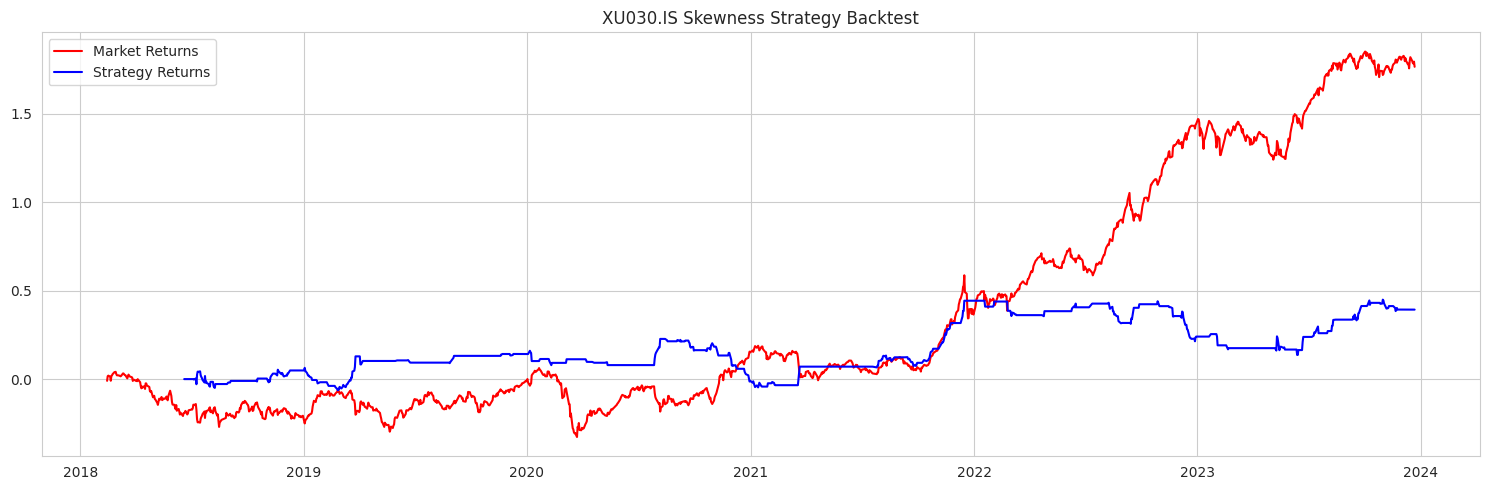

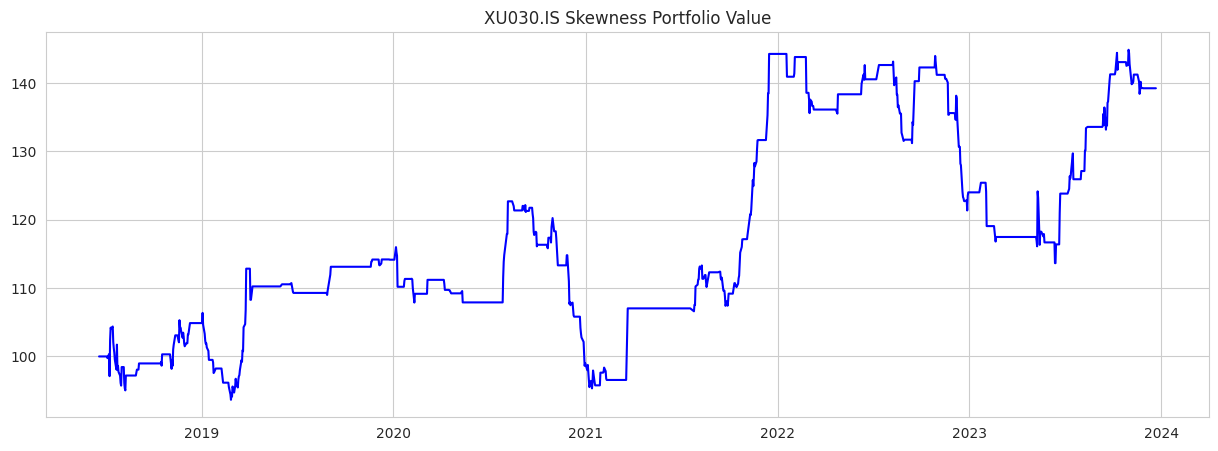

None
Daywise performance for XU030.IS
----------------------------------------------------------------
Returns             1.763975
R_Mean              0.001213
R_Std_Dev           0.018288
R_Skew             -0.539816
R_Kurtosis          4.205322
R_Sharpe            1.053056
Str_Returns         0.392405
Str_R_Mean          0.000287
Str_R_Std_Dev       0.009732
Str_R_Skew          1.471528
Str_R_Kurtosis     23.664653
SharpeRatio         0.468254
TotalWins         188.000000
TotalLosses       187.000000
TotalTrades       375.000000
HitRatio            0.500000
CAGR                0.058182
MaxDrawdown         0.223068
dtype: float64
Tradewise performance for XU030.IS
----------------------------------------------------------------
TotalWins            85.0000
TotalLosses          74.0000
TotalTrades         159.0000
HitRatio              0.5346
AvgWinRet             0.0221
AvgLossRet           -0.0201
WinByLossRet          1.1000
RetVar                0.0281
NormHitRatio          0.5582

<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:8, LMA:98
----------------------------------------------------------------
Performance plots for XU100.IS
----------------------------------------------------------------


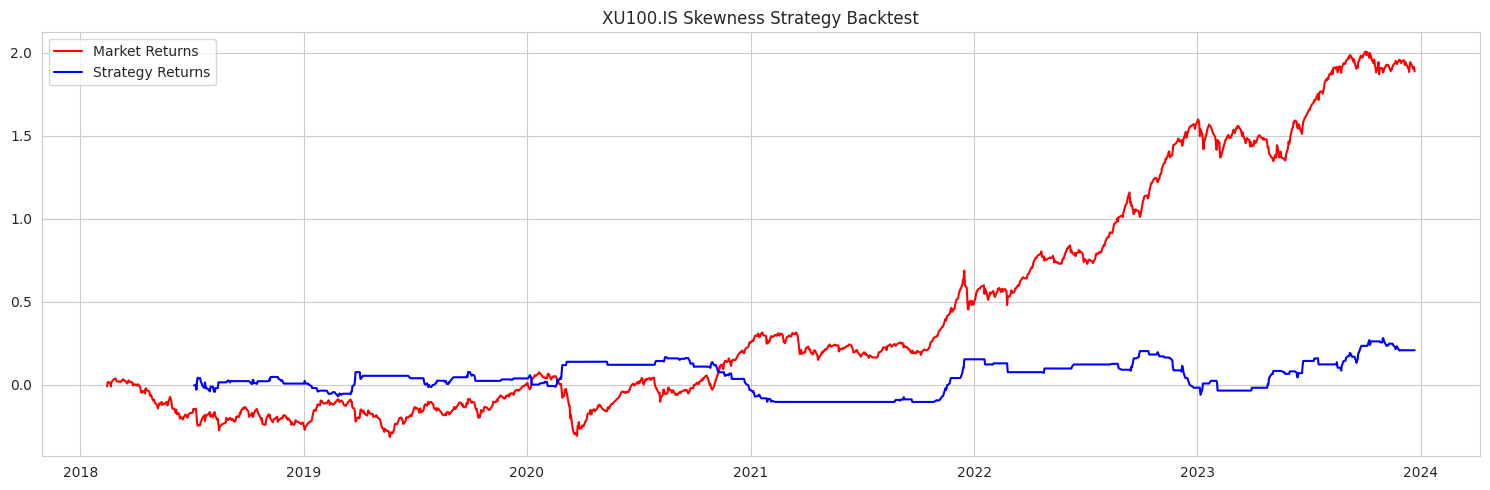

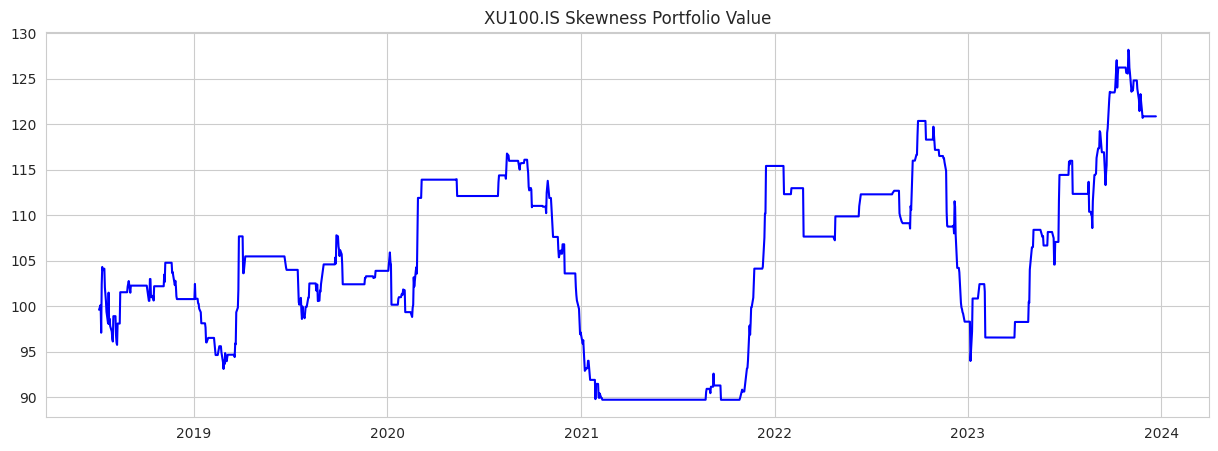

None
Daywise performance for XU100.IS
----------------------------------------------------------------
Returns             1.887197
R_Mean              0.001291
R_Std_Dev           0.017492
R_Skew             -0.716589
R_Kurtosis          4.698697
R_Sharpe            1.171451
Str_Returns         0.208561
Str_R_Mean          0.000153
Str_R_Std_Dev       0.008608
Str_R_Skew          0.570113
Str_R_Kurtosis     13.564689
SharpeRatio         0.282187
TotalWins         162.000000
TotalLosses       180.000000
TotalTrades       342.000000
HitRatio            0.470000
CAGR                0.032891
MaxDrawdown         0.231434
dtype: float64
Tradewise performance for XU100.IS
----------------------------------------------------------------
TotalWins            95.0000
TotalLosses          77.0000
TotalTrades         172.0000
HitRatio              0.5523
AvgWinRet             0.0184
AvgLossRet           -0.0200
WinByLossRet          0.9200
RetVar                0.0247
NormHitRatio          0.5317

<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:19, LMA:62
----------------------------------------------------------------
Performance plots for KOZAL.IS
----------------------------------------------------------------


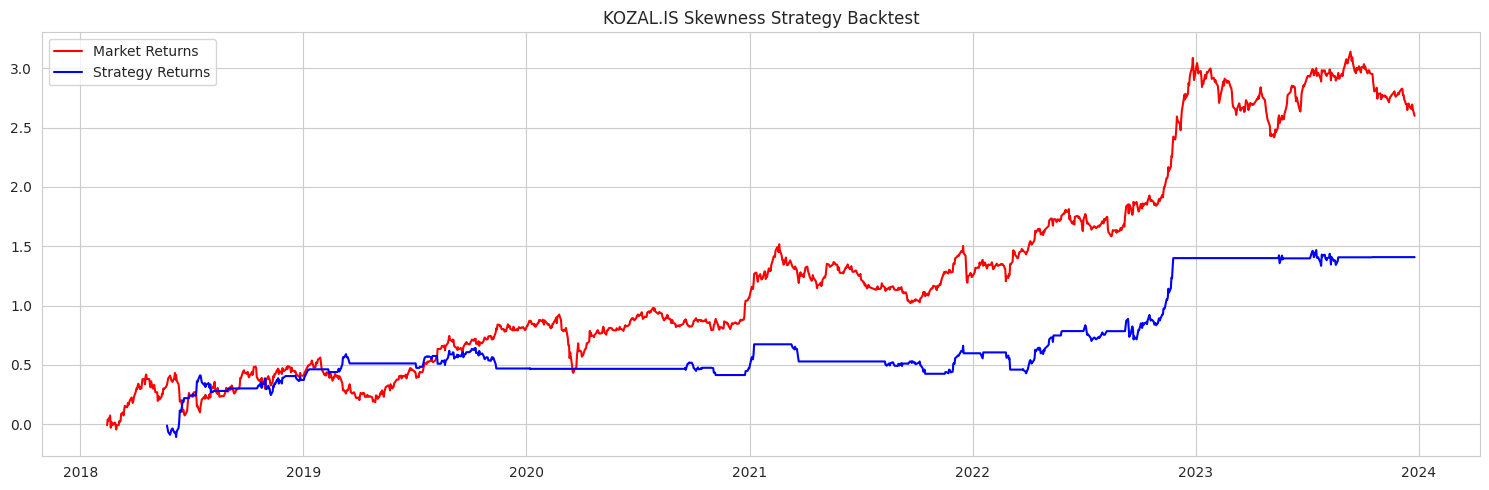

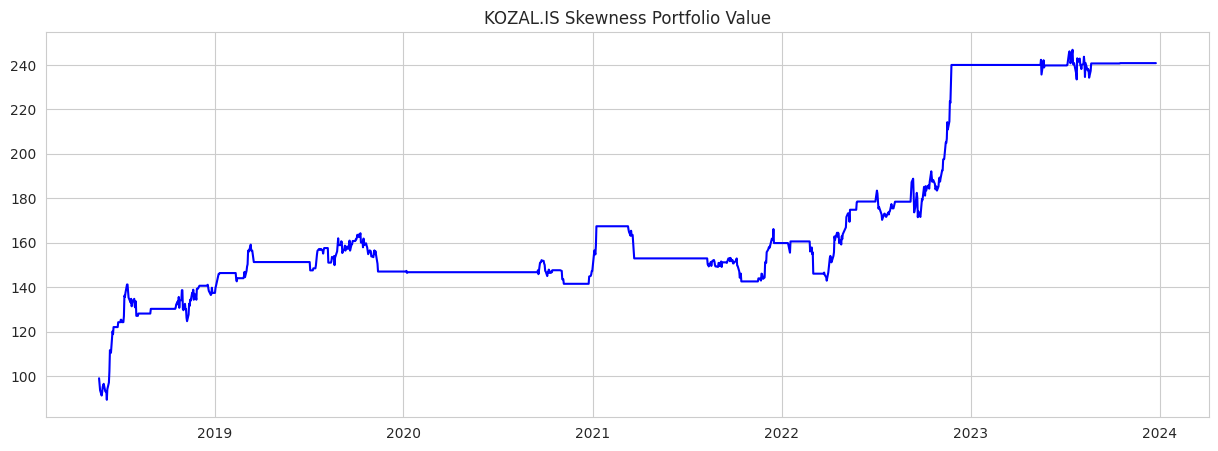

None
Daywise performance for KOZAL.IS
----------------------------------------------------------------
Returns             2.598508
R_Mean              0.001747
R_Std_Dev           0.030397
R_Skew              0.118397
R_Kurtosis          2.247485
R_Sharpe            0.912612
Str_Returns         1.408335
Str_R_Mean          0.000994
Str_R_Std_Dev       0.016463
Str_R_Skew          0.668309
Str_R_Kurtosis     12.147704
SharpeRatio         0.958346
TotalWins         230.000000
TotalLosses       188.000000
TotalTrades       418.000000
HitRatio            0.550000
CAGR                0.161770
MaxDrawdown         0.148315
dtype: float64
Tradewise performance for KOZAL.IS
----------------------------------------------------------------
TotalWins           57.0000
TotalLosses         38.0000
TotalTrades         95.0000
HitRatio             0.6000
AvgWinRet            0.0513
AvgLossRet          -0.0399
WinByLossRet         1.2900
RetVar               0.0668
NormHitRatio         0.6587
OptimalT

<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:4, LMA:86
----------------------------------------------------------------
Performance plots for THYAO.IS
----------------------------------------------------------------


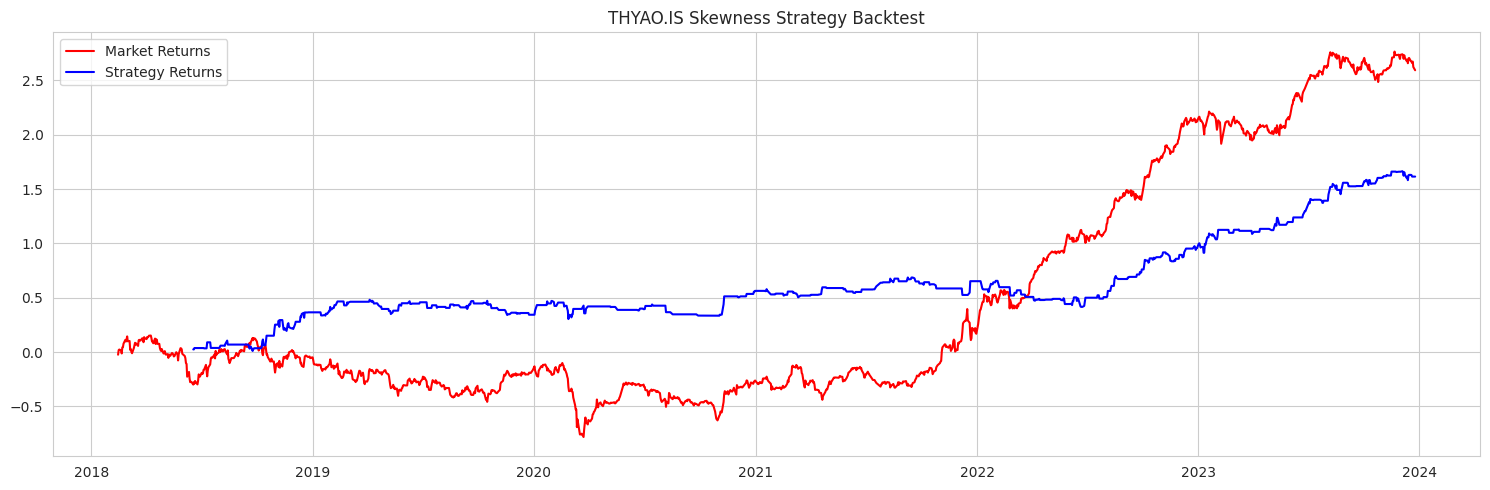

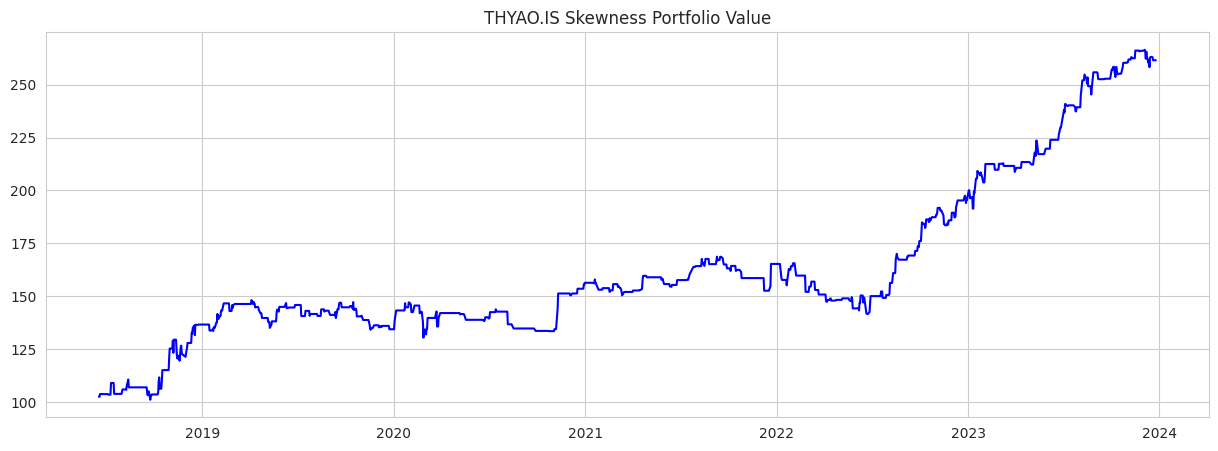

None
Daywise performance for THYAO.IS
----------------------------------------------------------------
Returns             2.594106
R_Mean              0.001745
R_Std_Dev           0.028333
R_Skew              0.140363
R_Kurtosis          3.455467
R_Sharpe            0.977440
Str_Returns         1.615456
Str_R_Mean          0.001155
Str_R_Std_Dev       0.015207
Str_R_Skew          0.850129
Str_R_Kurtosis      9.695083
SharpeRatio         1.205429
TotalWins         222.000000
TotalLosses       186.000000
TotalTrades       408.000000
HitRatio            0.540000
CAGR                0.178237
MaxDrawdown         0.160466
dtype: float64
Tradewise performance for THYAO.IS
----------------------------------------------------------------
TotalWins           173.0000
TotalLosses         133.0000
TotalTrades         306.0000
HitRatio              0.5654
AvgWinRet             0.0264
AvgLossRet           -0.0222
WinByLossRet          1.1900
RetVar                0.0278
NormHitRatio          0.6073

<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:6, LMA:95
----------------------------------------------------------------
Performance plots for YKBNK.IS
----------------------------------------------------------------


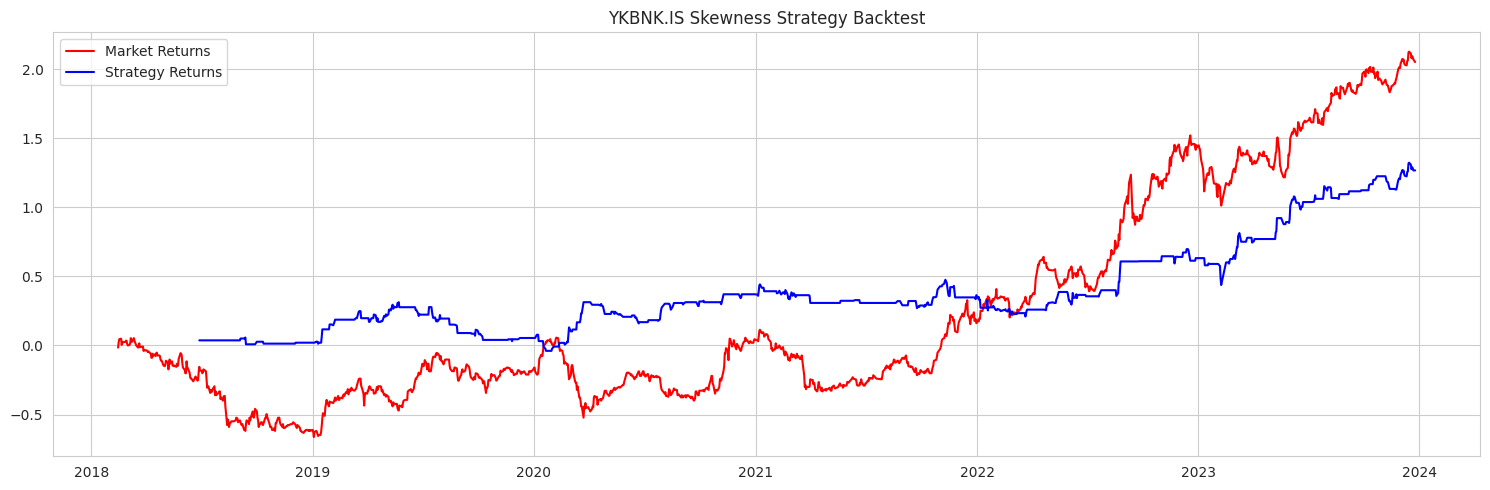

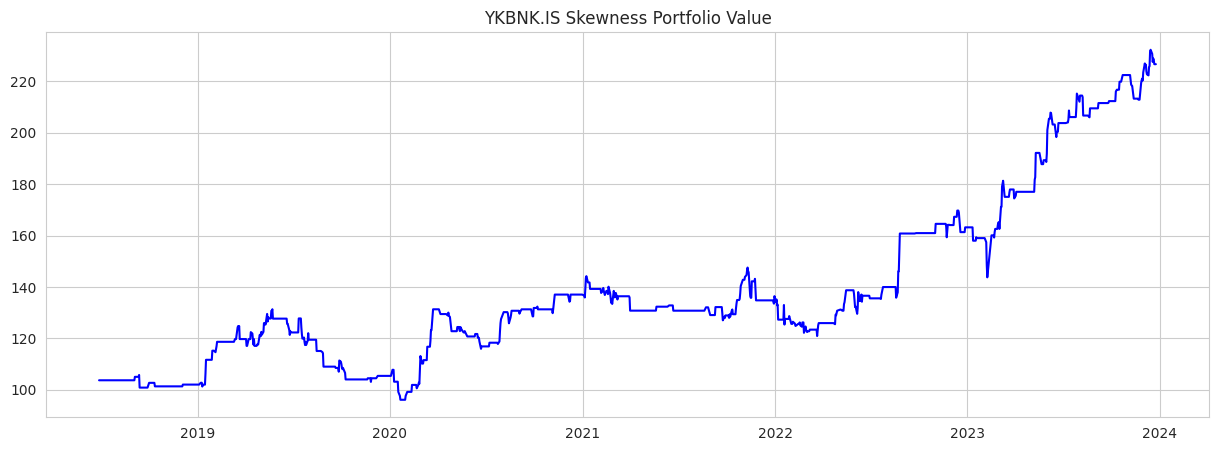

None
Daywise performance for YKBNK.IS
----------------------------------------------------------------
Returns             2.050938
R_Mean              0.001379
R_Std_Dev           0.028135
R_Skew             -0.009710
R_Kurtosis          2.551153
R_Sharpe            0.778217
Str_Returns         1.266948
Str_R_Mean          0.000911
Str_R_Std_Dev       0.015161
Str_R_Skew          1.146555
Str_R_Kurtosis     16.201826
SharpeRatio         0.953677
TotalWins         206.000000
TotalLosses       178.000000
TotalTrades       384.000000
HitRatio            0.540000
CAGR                0.149840
MaxDrawdown         0.268300
dtype: float64
Tradewise performance for YKBNK.IS
----------------------------------------------------------------
TotalWins           114.0000
TotalLosses          77.0000
TotalTrades         191.0000
HitRatio              0.5969
AvgWinRet             0.0305
AvgLossRet           -0.0287
WinByLossRet          1.0600
RetVar                0.0341
NormHitRatio          0.6114

<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeWarning: invalid value encountered in scalar power
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
<ipython-input-28-b3db9ca4dfeb>:156: RuntimeW

Most optimal cross-over pair is SMA:18, LMA:86
----------------------------------------------------------------
Performance plots for ETH-USD
----------------------------------------------------------------


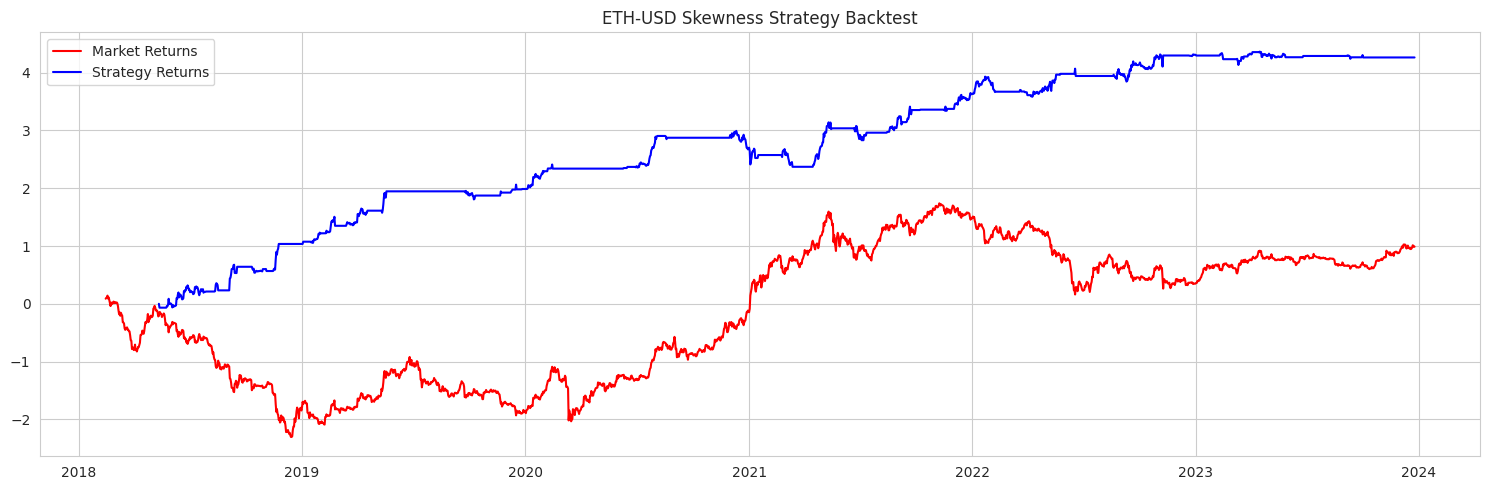

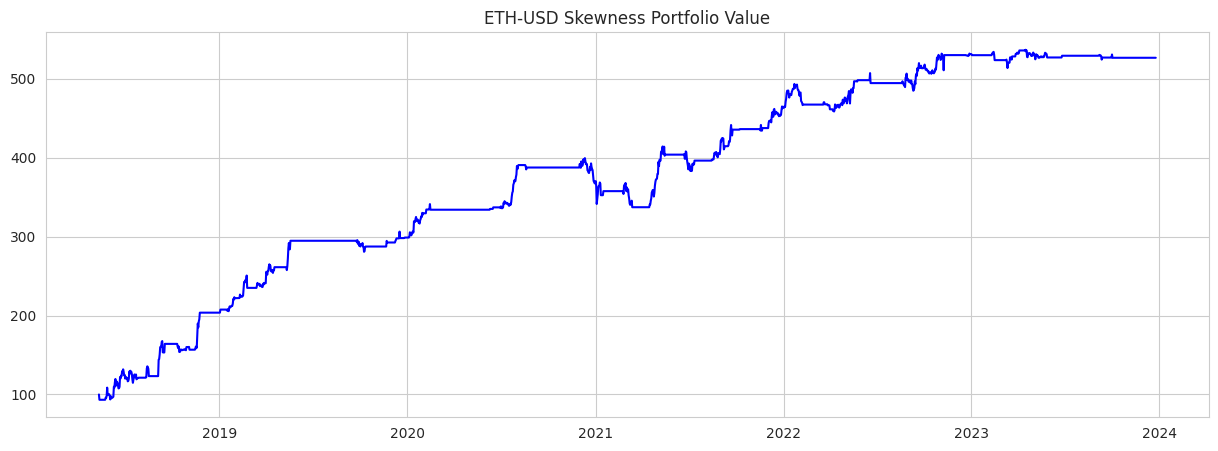

None
Daywise performance for ETH-USD
----------------------------------------------------------------
Returns             0.989018
R_Mean              0.000462
R_Std_Dev           0.046512
R_Skew             -1.070838
R_Kurtosis         12.343140
R_Sharpe            0.157661
Str_Returns         4.263583
Str_R_Mean          0.002076
Str_R_Std_Dev       0.026831
Str_R_Skew          0.581279
Str_R_Kurtosis     13.969201
SharpeRatio         1.228130
TotalWins         390.000000
TotalLosses       324.000000
TotalTrades       714.000000
HitRatio            0.550000
CAGR                0.327544
MaxDrawdown         0.155727
dtype: float64
Tradewise performance for ETH-USD
----------------------------------------------------------------
TotalWins            85.0000
TotalLosses          42.0000
TotalTrades         127.0000
HitRatio              0.6693
AvgWinRet             0.0837
AvgLossRet           -0.0678
WinByLossRet          1.2300
RetVar                0.1133
NormHitRatio          0.7140
O

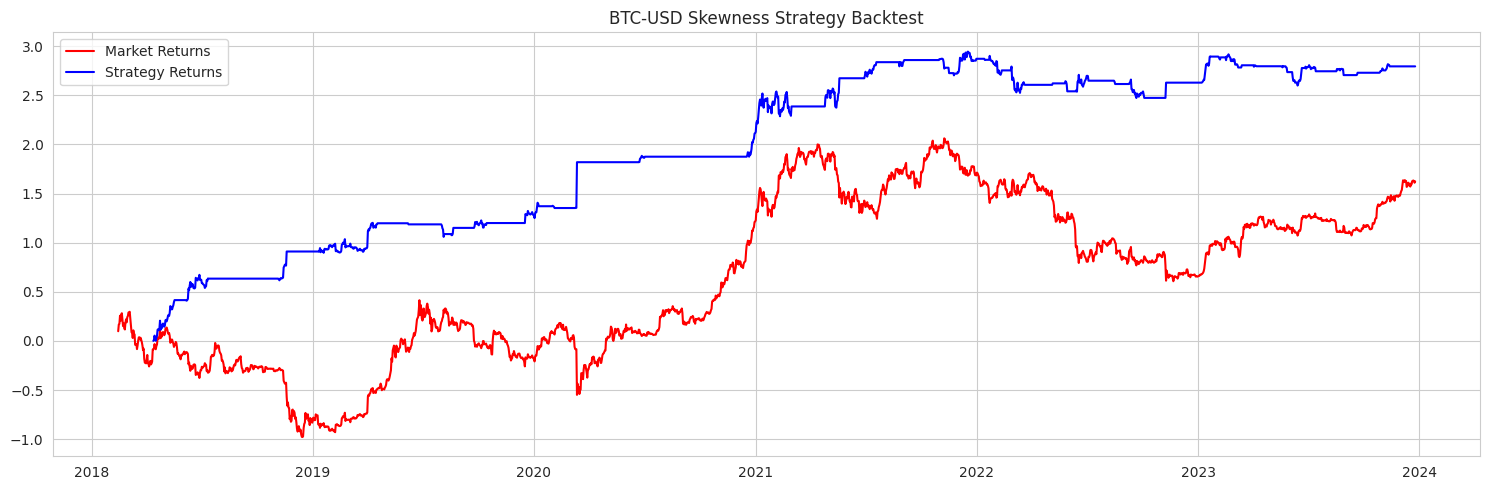

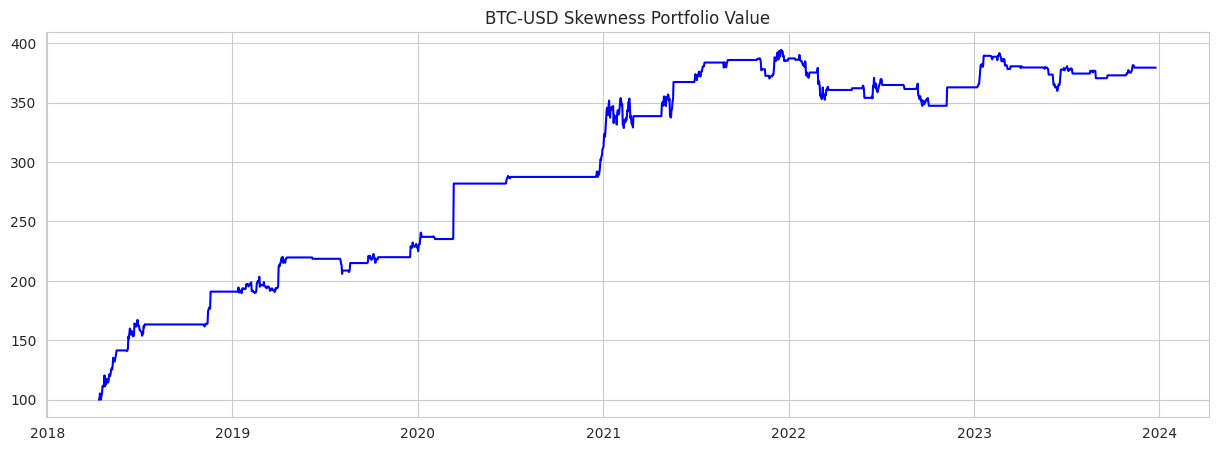

None
Daywise performance for BTC-USD
----------------------------------------------------------------
Returns             1.623793
R_Mean              0.000758
R_Std_Dev           0.035804
R_Skew             -1.059523
R_Kurtosis         15.795250
R_Sharpe            0.336268
Str_Returns         2.793747
Str_R_Mean          0.001341
Str_R_Std_Dev       0.021575
Str_R_Skew          5.097596
Str_R_Kurtosis    114.689147
SharpeRatio         0.986862
TotalWins         342.000000
TotalLosses       287.000000
TotalTrades       629.000000
HitRatio            0.540000
CAGR                0.255416
MaxDrawdown         0.119671
dtype: float64
Tradewise performance for BTC-USD
----------------------------------------------------------------
TotalWins            62.0000
TotalLosses          47.0000
TotalTrades         109.0000
HitRatio              0.5688
AvgWinRet             0.0747
AvgLossRet           -0.0391
WinByLossRet          1.9100
RetVar                0.0973
NormHitRatio          0.7161
O

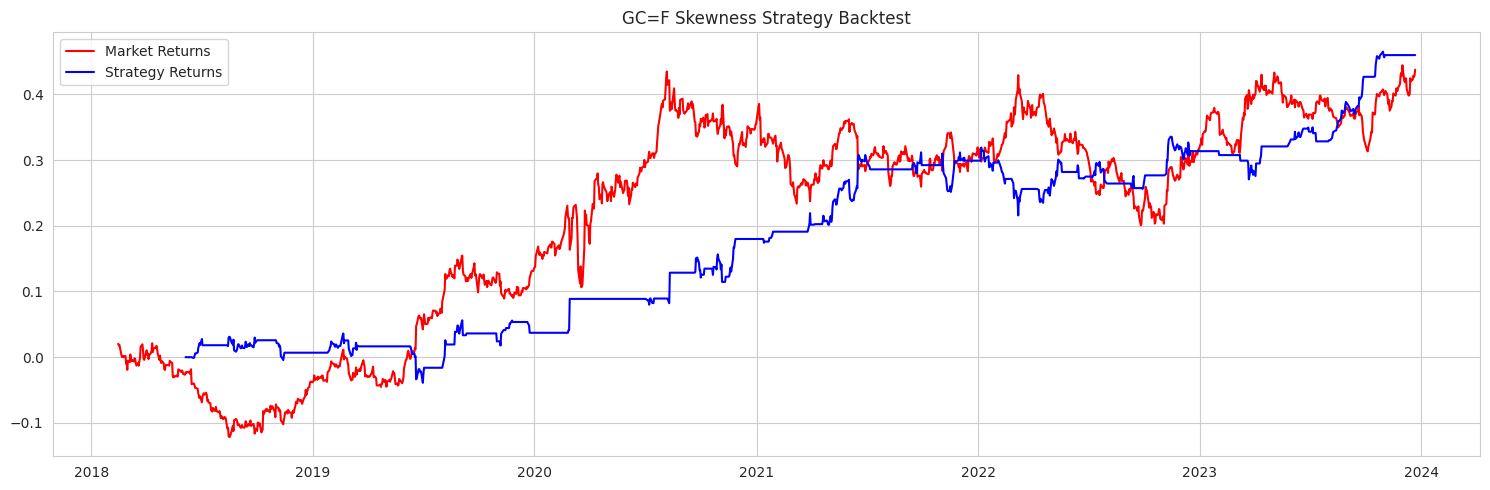

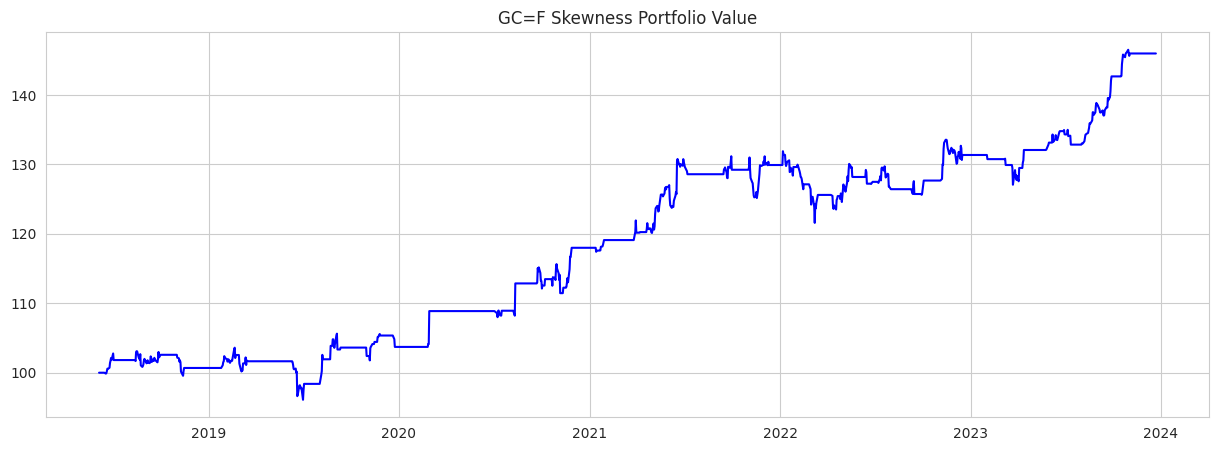

None
Daywise performance for GC=F
----------------------------------------------------------------
Returns             0.437548
R_Mean              0.000296
R_Std_Dev           0.009481
R_Skew             -0.167413
R_Kurtosis          4.548855
R_Sharpe            0.496351
Str_Returns         0.459723
Str_R_Mean          0.000328
Str_R_Std_Dev       0.005319
Str_R_Skew          1.488668
Str_R_Kurtosis     18.687642
SharpeRatio         0.979960
TotalWins         252.000000
TotalLosses       218.000000
TotalTrades       470.000000
HitRatio            0.540000
CAGR                0.066752
MaxDrawdown         0.078236
dtype: float64
Tradewise performance for GC=F
----------------------------------------------------------------
TotalWins            78.0000
TotalLosses          47.0000
TotalTrades         125.0000
HitRatio              0.6240
AvgWinRet             0.0127
AvgLossRet           -0.0113
WinByLossRet          1.1200
RetVar                0.0155
NormHitRatio          0.6507
Optimal

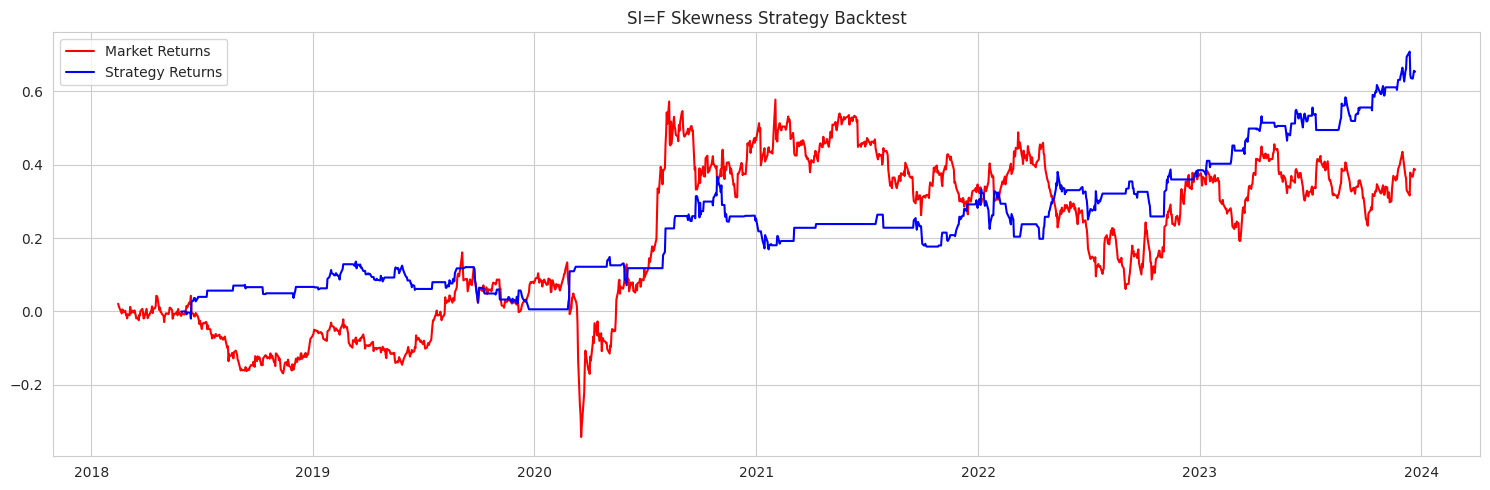

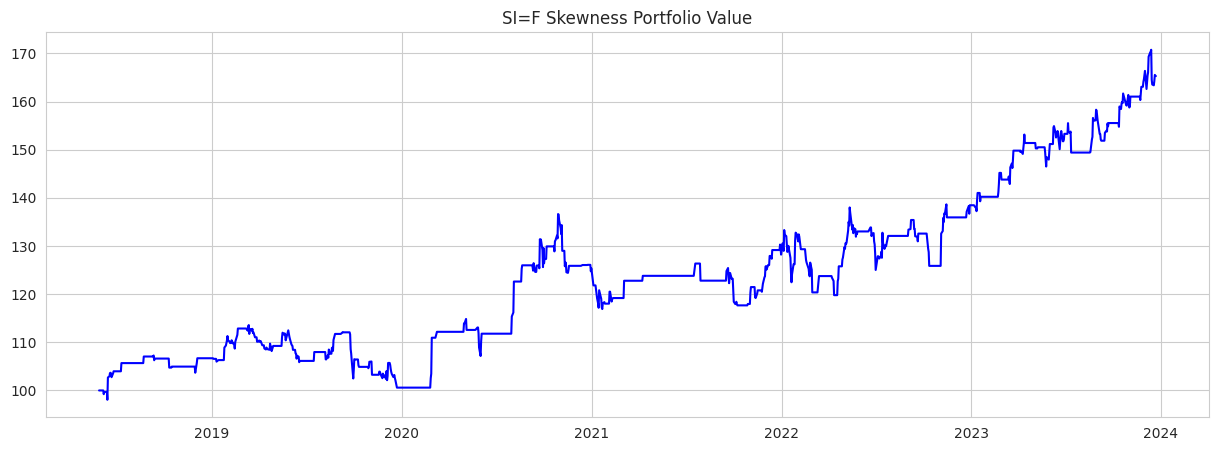

None
Daywise performance for SI=F
----------------------------------------------------------------
Returns             0.386098
R_Mean              0.000262
R_Std_Dev           0.019230
R_Skew             -0.451496
R_Kurtosis          5.969738
R_Sharpe            0.216091
Str_Returns         0.653020
Str_R_Mean          0.000465
Str_R_Std_Dev       0.009891
Str_R_Skew          0.937736
Str_R_Kurtosis     12.250823
SharpeRatio         0.746474
TotalWins         237.000000
TotalLosses       231.000000
TotalTrades       468.000000
HitRatio            0.510000
CAGR                0.089657
MaxDrawdown         0.144448
dtype: float64
Tradewise performance for SI=F
----------------------------------------------------------------
TotalWins           102.0000
TotalLosses          68.0000
TotalTrades         170.0000
HitRatio              0.6000
AvgWinRet             0.0198
AvgLossRet           -0.0200
WinByLossRet          0.9900
RetVar                0.0245
NormHitRatio          0.5967
Optimal

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Most optimal cross-over pair is SMA:15, LMA:70
----------------------------------------------------------------
Performance plots for CL=F
----------------------------------------------------------------


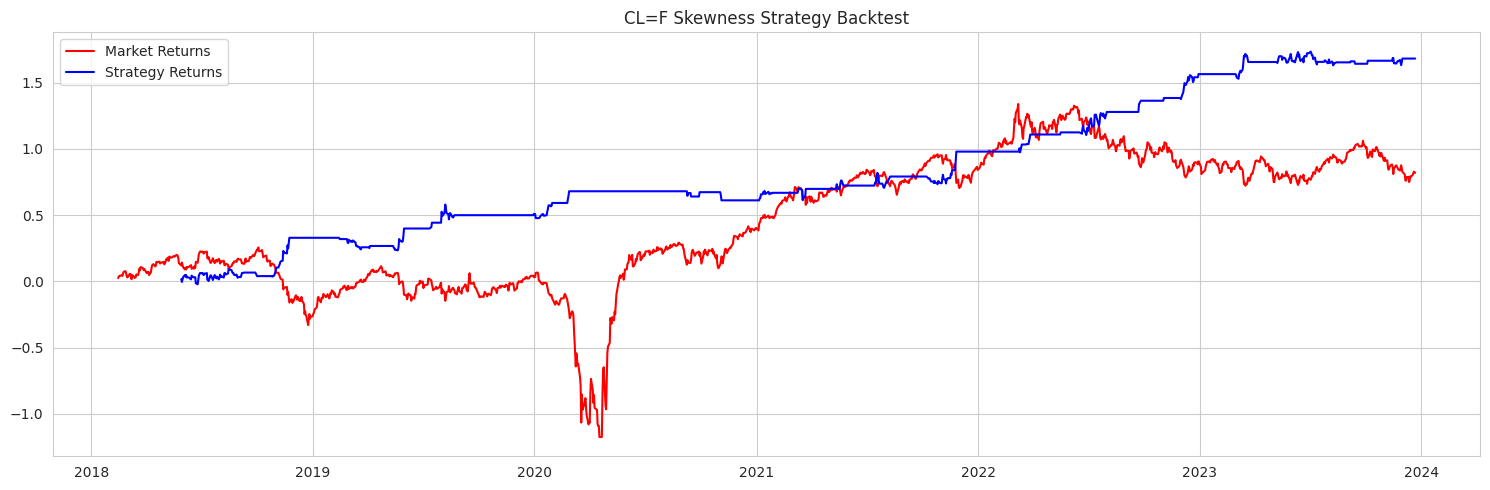

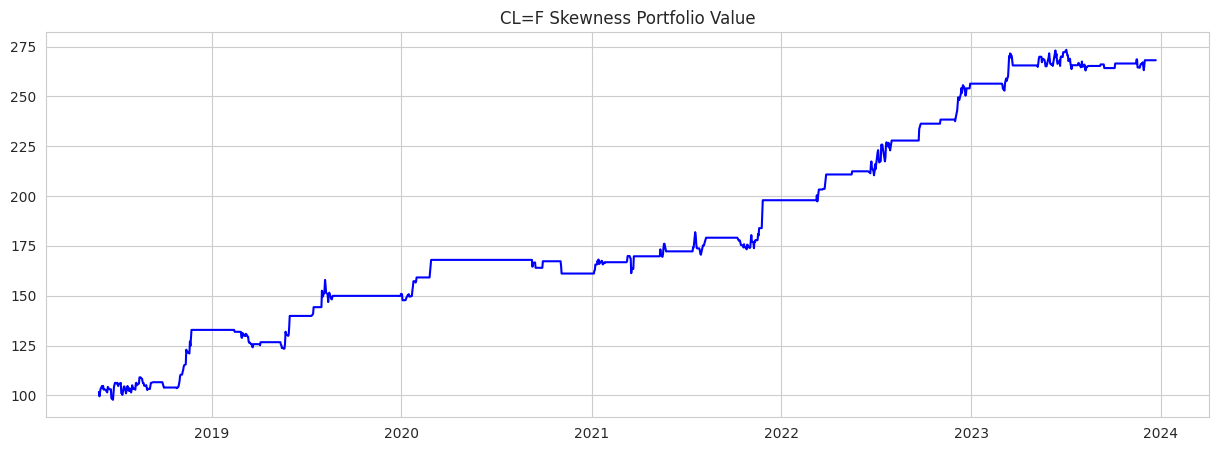

None
Daywise performance for CL=F
----------------------------------------------------------------
Returns             0.819025
R_Mean              0.000556
R_Std_Dev           0.032420
R_Skew              0.046925
R_Kurtosis         24.147288
R_Sharpe            0.272077
Str_Returns         1.681578
Str_R_Mean          0.001199
Str_R_Std_Dev       0.012926
Str_R_Skew          2.437387
Str_R_Kurtosis     20.031374
SharpeRatio         1.471978
TotalWins         202.000000
TotalLosses       177.000000
TotalTrades       379.000000
HitRatio            0.530000
CAGR                0.183546
MaxDrawdown         0.071457
dtype: float64
Tradewise performance for CL=F
----------------------------------------------------------------
TotalWins           69.0000
TotalLosses         29.0000
TotalTrades         98.0000
HitRatio             0.7041
AvgWinRet            0.0352
AvgLossRet          -0.0258
WinByLossRet         1.3600
RetVar               0.0399
NormHitRatio         0.7647
OptimalTradeSize

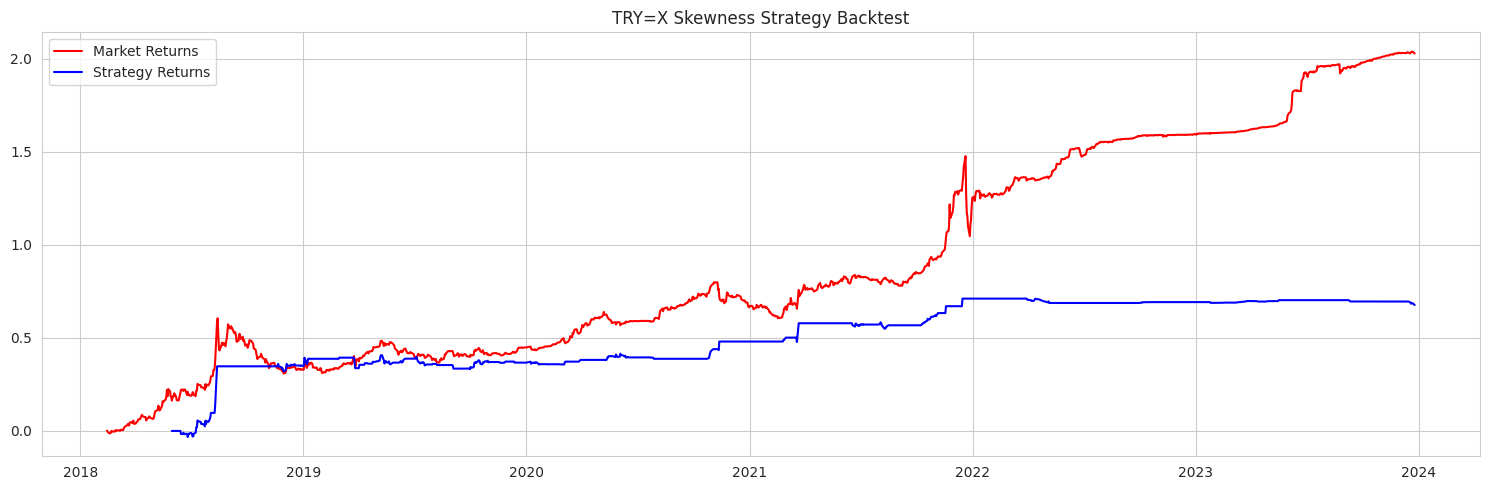

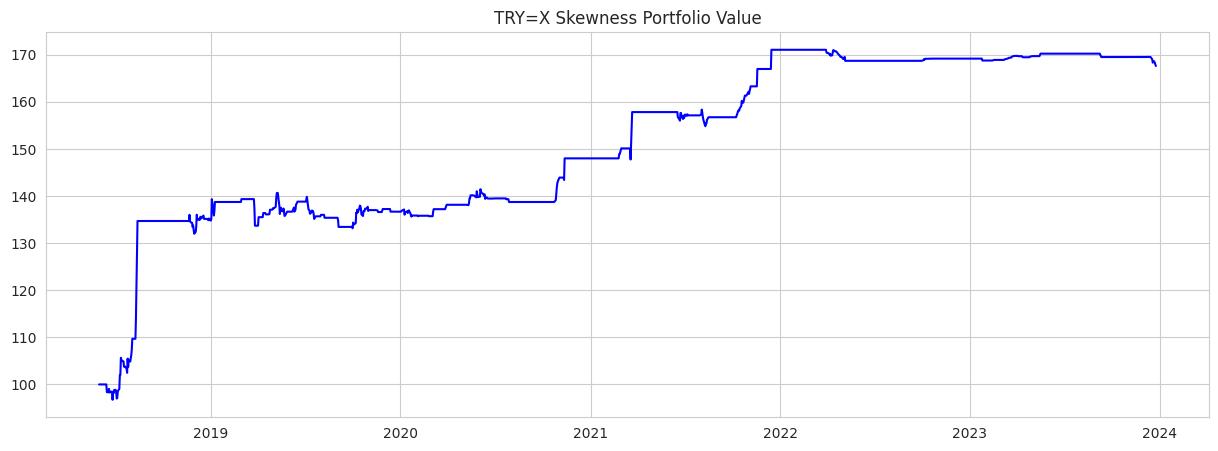

None
Daywise performance for TRY=X
----------------------------------------------------------------
Returns             2.027135
R_Mean              0.001327
R_Std_Dev           0.013813
R_Skew              0.190943
R_Kurtosis         75.641664
R_Sharpe            1.524648
Str_Returns         0.676286
Str_R_Mean          0.000466
Str_R_Std_Dev       0.007515
Str_R_Skew         16.234446
Str_R_Kurtosis    406.839453
SharpeRatio         0.983865
TotalWins         181.000000
TotalLosses       140.000000
TotalTrades       321.000000
HitRatio            0.560000
CAGR                0.092127
MaxDrawdown         0.053487
dtype: float64
Tradewise performance for TRY=X
----------------------------------------------------------------
TotalWins            69.0000
TotalLosses          41.0000
TotalTrades         110.0000
HitRatio              0.6273
AvgWinRet             0.0152
AvgLossRet           -0.0091
WinByLossRet          1.6700
RetVar                0.0248
NormHitRatio          0.7376
Optim

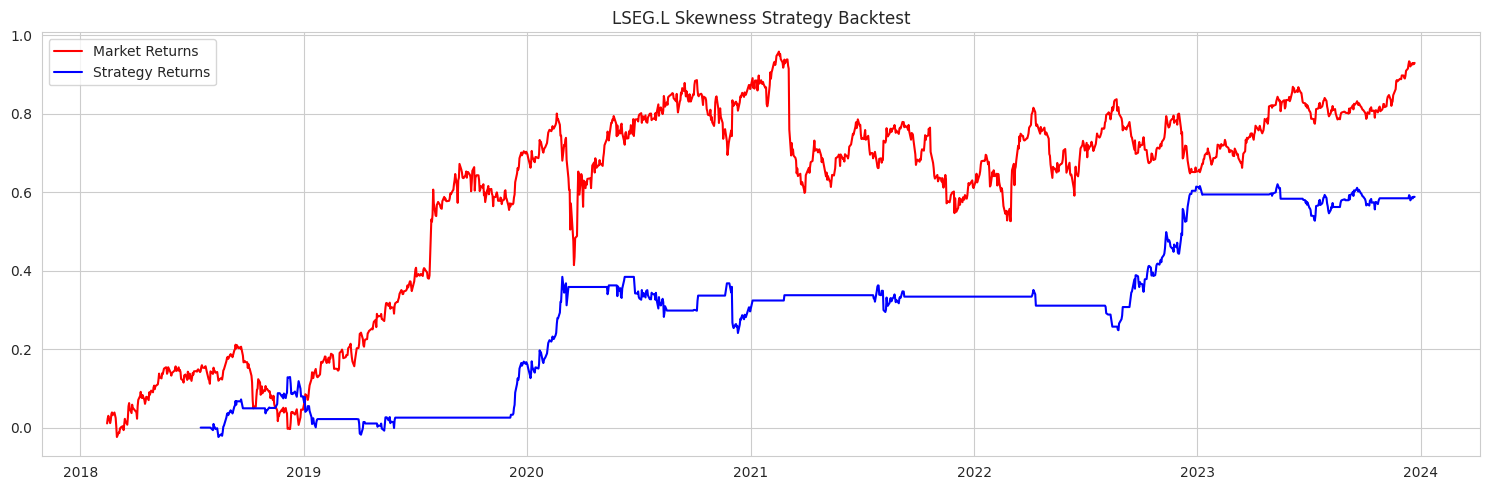

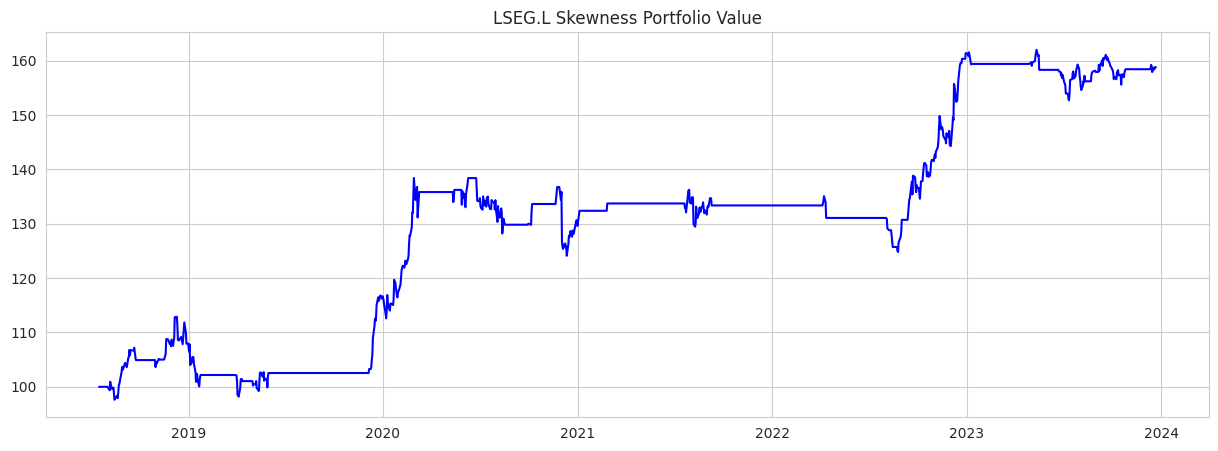

None
Daywise performance for LSEG.L
----------------------------------------------------------------
Returns             0.929077
R_Mean              0.000628
R_Std_Dev           0.016974
R_Skew             -0.146616
R_Kurtosis         11.715136
R_Sharpe            0.587096
Str_Returns         0.587859
Str_R_Mean          0.000428
Str_R_Std_Dev       0.008306
Str_R_Skew         -0.522078
Str_R_Kurtosis     20.758347
SharpeRatio         0.817099
TotalWins         252.000000
TotalLosses       213.000000
TotalTrades       465.000000
HitRatio            0.540000
CAGR                0.082197
MaxDrawdown         0.130211
dtype: float64
Tradewise performance for LSEG.L
----------------------------------------------------------------
TotalWins           44.0000
TotalLosses         28.0000
TotalTrades         72.0000
HitRatio             0.6111
AvgWinRet            0.0255
AvgLossRet          -0.0191
WinByLossRet         1.3400
RetVar               0.0370
NormHitRatio         0.6771
OptimalTrade

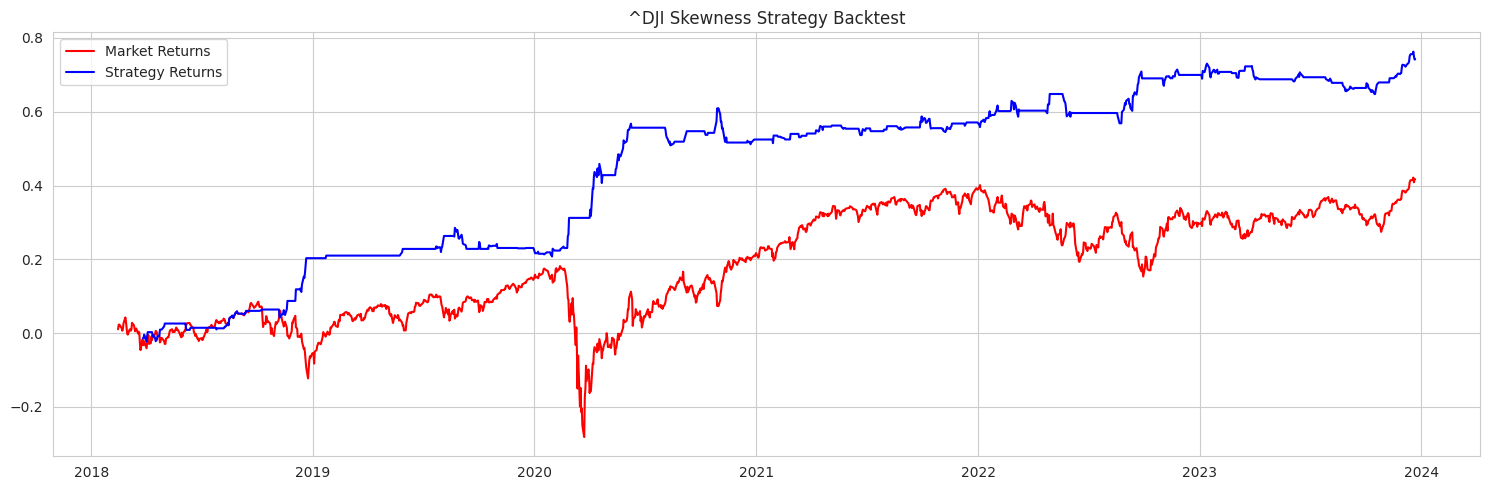

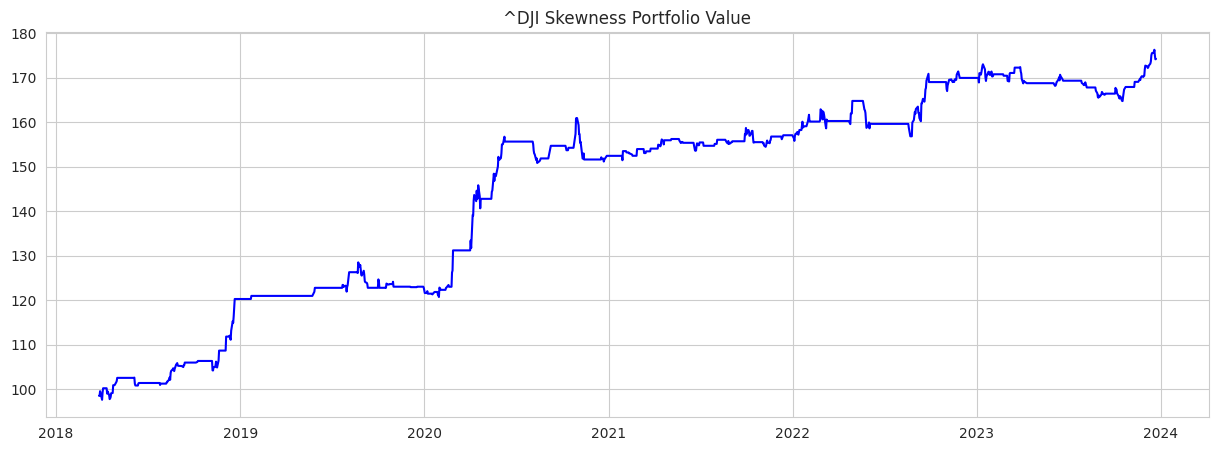

None
Daywise performance for ^DJI
----------------------------------------------------------------
Returns             0.416906
R_Mean              0.000283
R_Std_Dev           0.012910
R_Skew             -0.917649
R_Kurtosis         20.208453
R_Sharpe            0.347554
Str_Returns         0.741993
Str_R_Mean          0.000513
Str_R_Std_Dev       0.006256
Str_R_Skew          2.437441
Str_R_Kurtosis     22.787348
SharpeRatio         1.301135
TotalWins         258.000000
TotalLosses       206.000000
TotalTrades       464.000000
HitRatio            0.560000
CAGR                0.099461
MaxDrawdown         0.060779
dtype: float64
Tradewise performance for ^DJI
----------------------------------------------------------------
TotalWins            95.0000
TotalLosses          61.0000
TotalTrades         156.0000
HitRatio              0.6090
AvgWinRet             0.0147
AvgLossRet           -0.0107
WinByLossRet          1.3700
RetVar                0.0205
NormHitRatio          0.6815
Optimal

In [35]:
strategy = "MSC"

testing_range = False
for stock in stock_list:
        if (testing_range==True):
            for i in np.arange(9,22,1):
                k = TestStrategy(stock,i,100, strategy,messages=False, showCharts= False)
                print(f" i = {i} Information Ratio = {k} ")
        else:
            k = TestStrategy(stock, 22, 100, strategy=strategy, messages=False, showCharts = False)
            print(f" {strategy} Information Ratio = {k} ")

        print("=================================================================")
        #print(f" Stock: {stock}, M-Sharpe: {k},  SMA : {l}, EMA : {m}, MSC : {n}")
        print(f" Stock: {stock}, {strategy} Information Ratio: {k}")

#### print(LENGTH*"*")        
print('Fw tests complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
print(LENGTH*"*")



### PRINT RESULTS TO STREAM AND FILES <a name="print_results"></a>

In [36]:
%time

results = pd.DataFrame({'Stock':stock_name, 'Strategy' : strats, 'IR': Information_Ratios, 'Signal': COMMANDS, 'MDD': MDDs, 'R_Skew': R_Skews, 'Delta Skew': DELTA_SKEWs, 'R_Std_Dev' :R_Std_Devs, 'Str_R_Skew': Str_R_Skews, 'R_Sharpe': R_Sharpes, 'Str_Sharpe': sharpes, 'Returns ':returns, 'Str_Returns':str_returns,  'Hit Rate':nhrs,
                        'SumLast10Signals':Last_signal_Sum10, 'SMAs':SMAs, 'LMAs':LMAs, 'TP': AWRs, 'SL': ALRs, 'KellyR': Kellys, 'W:L': WinOverLoss, 'SharpeOverMDD': SharpeOverMDD   })

results = pd.DataFrame({'Stock':stock_name, 'Strategy' : strats, 'Signal': COMMANDS,'SMAs':SMAs, 'LMAs':LMAs,'IR': Information_Ratios, 'MDD': MDDs, 'Str_Sharpe': sharpes, 'Str_Returns':str_returns,  'Hit Rate':nhrs,
                           'W:L': WinOverLoss, 'SharpeOverMDD': SharpeOverMDD, 'KellyR': Kellys })


print('MSC Strategy applied to below assets with following performance:')
print(LENGTH * '-')

filename1 = f"01_MR-{END_DATE}_BackTest.csv"

# sorted = results[(results['Delta Skew'] > 0.0) ].sort_values(by=[ 'Delta Skew', 'IR', 'R_Skew', 'R_Std_Dev'], ascending=[False,False,False,True]).reset_index(drop=True)
sorted = results.sort_values(by=[ 'Str_Returns'], ascending=[False]).reset_index(drop=True)
#sorted = results[(results['R_Std_Dev'] < 0.05) & (results['Delta Skew'] > 0.0)].sort_values(by=[ 'Signal', 'IR', 'R_Skew', 'R_Std_Dev'], ascending=[False,False,False,True]).reset_index(drop=True)
#sorted = results[(results['Str_R_Skew'] > 0.14)].sort_values(by=[ 'Signal', 'Delta Skew'], ascending=[False,False]).reset_index(drop=True)
#sorted = results.sort_values(by=['IR'], ascending=[False]).reset_index(drop=True)
#sorted = results.sort_values(by=['Delta Skew'], ascending=[False]).reset_index(drop=True)
#sorted = results.sort_values(by=[ 'MDD', 'Str_R_Skew'], ascending=[True,True]).reset_index(drop=True)

print(sorted)
#os.chdir(working_dir+"\\MR_Portfolios")
sorted.to_csv(filename1)

print(LENGTH * '-')
print(f"Data written to {filename1}")
print(LENGTH * '%')

TR_TOP_TEN = sorted.Stock

print(LENGTH*"*")
print('Backtests complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
print(LENGTH*"*")



%time

filename1 = f"01_MR-{END_DATE}_FwTest.csv"

# SORTING VALUES AGAINST A COLUMN VALUE LIMIT

sorted2 = sorted[ (sorted['Str_Sharpe'] > 1)
                  #(sorted['R_Std_Dev'] < 0.027) &
                  #(sorted['Str_Sharpe'] > 1) &
                  #(sorted['Str_R_Skew'] > 0.0) &
                  #(sorted['Delta Skew'] > 0.0) &
                  #(sorted['W:L'] > 1) &
                  #(sorted['Signal'] != 'HOLD') &
                  #(sorted['Signal'] != 'SELL') &
                  #(sorted['SharpeOverMDD'] > 1) &
                  #(sorted['MDD'] < 0.15) &
                  #(sorted['Signal'] != 'STRONG SELL')].sort_values(by=[ 'SharpeOverMDD'], ascending=[False]).reset_index(drop=True)
                  ].sort_values(by=['Str_Returns'], ascending=[False]).reset_index(drop=True)

#sorted = results.sort_values(by=[ 'Signal', 'Delta Skew'], ascending=[False,False]).reset_index(drop=True)
#sorted = results.sort_values(by=[ 'MDD', 'Delta Skew'], ascending=[True,False]).reset_index(drop=True)


print(sorted2)
BIST_Top_22 = sorted2.Stock

#os.chdir(working_dir+"\\MR_Portfolios")
sorted.to_csv("filename1")
print(LENGTH * '-')
print(f"Data written to {filename1}")
print(LENGTH * '%')

# with open(writePath, 'a') as f:
#     dfAsString = df.to_string(header=False, index=False)
#     f.write(dfAsString)



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs
MSC Strategy applied to below assets with following performance:
----------------------------------------------------------------
       Stock Strategy      Signal  SMAs  LMAs      IR       MDD  Str_Sharpe  \
0    ETH-USD      MSC        SELL    18    86  3.2746  0.155727      1.2281   
1    BTC-USD      MSC        SELL    21    53  1.1700  0.119671      0.9869   
2       CL=F      MSC        SELL    15    70  0.8626  0.071457      1.4720   
3   THYAO.IS      MSC  STRONG BUY     4    86 -0.9787  0.160466      1.2054   
4   KOZAL.IS      MSC         BUY    19    62 -1.1902  0.148315      0.9583   
5   YKBNK.IS      MSC         BUY     6    95 -0.7840  0.268300      0.9537   
6       ^DJI      MSC        SELL    12    26  0.3251  0.060779      1.3011   
7      TRY=X      MSC         BUY    10    62 -1.3508  0.053487      0.9839   
8       SI=F      MSC         BUY     7    65  0.2669  0.144448      0.7465   
9     LSEG.L

In [37]:
print(LENGTH*"*")
print('Fw testing complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
print(LENGTH*"*")
start_time = datetime.now()

****************************************************************
Fw testing complete...Time elapsed (hh:mm:ss.ms) 0:08:45.392252
****************************************************************
